## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../config/initialize_nospark.ipynb

import json
import shutil

## TODO
* how to generalize to regression problems?
  * easier to create a separate process?

## Set root dir path

In [3]:
ROOT='/Users/joshplotkin/Dropbox/data_science/'\
    'modeling-football-outcomes/'
os.chdir(ROOT)

MODELS_DIR=f'{ROOT}/models'

## Initialize
* set model ID
* remove this model ID's directory if it exists
* create directory

In [4]:
MODEL_ID = '0619_test_b'

# if os.path.exists(MODEL_ID):
#     print('Directory models/{} **EXISTS**'.format(MODEL_ID))
# else:
#     print('Directory models/{} **DOES NOT EXIST**'.format(MODEL_ID))

In [5]:
## wipe out existing directory
if os.path.exists(MODEL_ID):
    shutil.rmtree(MODEL_ID)
os.mkdir(MODEL_ID)

## Generate dictionary version of model.json

In [6]:
model_dict = {
    'model_id': MODEL_ID,
    'models_dir': MODELS_DIR
}

### Source data for model

#### Hive Tables
* features
* tables

In [7]:
model_dict['features_tbl'] = 'features.combined_0601'
model_dict['labels_tbl'] = 'labels.combined_0601'

##### Note: can modify/create features/labels tables here

#### Columns from Hive tables
* index: unique identifier in features/labels table (must be in both)
* label column, and indicator of what is a positive label
  * currently not supported: multi-class
  * code will binarize
* list of features

In [8]:
model_dict['index'] = ['game_id']
model_dict['label_col'] = 'final_margin'
model_dict['pos_labels'] = [1]
model_dict['neg_labels'] = [-1]
model_dict['features_list'] = [        
        'home_field___h_consecutive_home',
        'home_field___h_home__ovr_wr_last_4_games',
        'home_field___h_home__ovr_wr_last_8_games',
        'home_field___h_home__ovr_wr_ytd',
        'home_field___v_consecutive_visitor',
        'home_field___v_visitor__ovr_wr_last_4_games',
        'home_field___v_visitor__ovr_wr_last_8_games',
        'home_field___v_visitor__ovr_wr_ytd',
        'matchup___h_wr_past_3_seasons',
        'matchup___is_same_division',
        'rankings___h__dave_or_wtddvoa',
        'rankings___h__defensedvoa',
        'rankings___h__estim_winrate',
        'rankings___h__offensedvoa',
        'rankings___h__s_t_dvoa',
        'rankings___v__dave_or_wtddvoa',
        'rankings___v__defensedvoa',
        'rankings___v__estim_winrate',
        'rankings___v__offensedvoa',
        'rankings___v__s_t_dvoa',
        'team_history___h_ovr_wr_past_2_seasons',
        'team_history___h_ovr_wr_past_3_seasons',
        'team_history___h_ovr_wr_ytd',
        'team_history___v_ovr_wr_past_2_seasons',
        'team_history___v_ovr_wr_past_3_seasons',
        'team_history___v_ovr_wr_ytd',
        'time_date___game_time_eastern',
        'time_date___is_sunday',
        'time_date___week_id',
        'travel___h_body_clock_from_last_wk',
        'travel___h_days_since_last_game',
        'travel___h_same_stadium_last_game',
        'travel___h_travel_from_last_game_decay',
        'travel___h_tz_change_last_10_days',
        'travel___v_body_clock_from_last_wk',
        'travel___v_days_since_last_game',
        'travel___v_home_body_time',
        'travel___v_same_stadium_last_game',
        'travel___v_travel_from_last_game_decay',
        'travel___v_tz_change_last_10_days',
        'weather___humidity_pct',
        'weather___temperature',
        'weather___wind_chill',
        'weather___wind_mph',
        'line___h_ml',
        'line___close_ou',
        'line___h_close_line']

model_dict['features_list'].sort()

### Cross-Validation Sets
* random seeds for reproducibility
* number of folds for cross-validation (value of <= 1 doesn't do k-fold
* global_dataset_proportions
 * proportion of the data for each of training, scoring only, holdout, and throwaway
 * generated using stratified sampling
* dimensional_dataset_proportions
 * post-processing after global_dataset_proportions
 * idea is to move specific field values, e.g. move certain seasons to the holdout set

#### Optional: use cross-validation data from another model

In [9]:
model_dict['model_cv_to_use'] = None

#### CV parameters, when not using another model CV

#### Sample usage for Dimensional Dataset Proportions

```python
model_dict['dimensional_dataset_proportions'] = {
        'throw_away': [
            {
                'vals': [
                    0
                ], 
                'dim': 'is_home',
                'prop_to_move': 1.0, 
                'from_groups': [
                    'training',
                    'holdout',
                    'scoring_only'
                ]
            }
        ]
    }
```

In [10]:
model_dict['fold_seed'] = 99
model_dict['dataset_seed'] = 9
model_dict['kfolds'] = 5
model_dict['strata_cols'] = ['season','week_id']

model_dict['global_dataset_proportions'] = {
        'training': 1.,
        'holdout': 0,
        'throw_away': 0,
        'scoring_only': 0
    }

# DEFAULT: model_dict['dimensional_dataset_proportions'] = {}
model_dict['dimensional_dataset_proportions'] = {
        'throw_away': [
            {
                'vals': [
                    1, 
                    2, 
                    3, 
                    4, 
                    17, 
                    18, 
                    19, 
                    20, 
                    21, 
                    22
                ], 
                'dim': 'week_id', 
                'prop_to_move': 1.0, 
                'from_groups': [
                    'training', 
                    'holdout', 
                    'scoring_only'
                ]
            }
        ],
        'holdout': [{
            'vals': [2016,2017],
            'dim': 'season',
            'prop_to_move': 1.0,
            'from_groups': ['training']}]
    }

### Model Choice
* package/class name as a string
* parameters as a dictionary

#### sklearn basic

In [11]:
# model_dict['model'] = 'sklearn.ensemble.GradientBoostingClassifier'
# model_dict['model_params'] = {
#     'learning_rate': 0.1, 
#     'n_estimators': 200, 
#     'max_features': 'auto', 
#     'subsample': 0.9, 
#     'random_state': 9, 
#     'max_depth': 12, 
# }

#### xgboost basic

In [12]:
model_dict['model'] = 'xgboost.XGBRegressor'
model_dict['model_params'] = {
        'n_jobs': 1,
        'learning_rate': 0.1,
        'n_estimators': 100, 
        'max_features': 'auto', 
        'booster': 'gbtree', 
        'silent': True, 
        'nthread': None, 
        'subsample': 0.5, 
        'random_state': 9, 
        'objective': 'reg:linear',
        'max_depth': 6, 
        'gamma': 0
}

#### Data to save

In [13]:
model_dict['save'] = {
    'cv_data': True,
    'serialized_models': True,
    'cv_scores': True,
    'holdout_scores': True
}

In [14]:
model_dict['actions'] = {
        'do_train_and_score_cv': True,
        'do_score_holdout': True,
        'do_evaluate': True
    }

#### Parts to execute

### Write out model.json file

In [15]:
model_json_path = 'model_configs/model__{}.json'.format(model_dict['model_id'])

with open(model_json_path,'w') as w:
    json.dump(model_dict, w, indent=4)

## Generate dictionary version of plots.json

In [16]:
evaluate_dict = {
    'model_id': MODEL_ID,
    'models_dir': MODELS_DIR
}

### Plot Labels
* labels --> names (note: keys should be strings)
* name for success rate

In [17]:
evaluate_dict['label_map'] = {
    '1': 'Won',
    '0': 'Lost'
}
evaluate_dict['success_name'] = 'Win Rate'

### Bins to plot
* plot_bins: 
   * Number of bins to plot (i.e. number of bars on the bar chart)
* bin_types:
   * "Bin" puts scores into uniform bins, e.g. [0, 0.10], (0.10, 0.20], ..., (0.9, 1.0]
   * "Percentile" bins scores into ntiles determined by plot_bins

In [18]:
evaluate_dict['bin_types'] = ['Bin', 'Percentile']
evaluate_dict['plot_bins'] = [10, 100]

### Threshold Metrics to Plot
* metrics evaluated at each of 100 score threshold points
* currently only supports Accuracy and F1

In [19]:
evaluate_dict['threshold_metrics'] = ['Accuracy','F1']

### Accuracy at Top 'N' plots

In [20]:
evaluate_dict['accuracy_at_topn'] = {
        'week_id__season': [1, 16],
        'season': [1, 200, 2]
}

### Regression Evaluation

In [21]:
evaluate_dict['regression_evaluation'] = {
    'comparison':  0, 
    'label': 'did_win', 
    'round_score': False
}

In [22]:
evaluate_dict['save'] = {
    'plots': False,
    'data': True
}

### Write out plots.json

In [23]:
eval_json_path = 'model_configs/evaluate__{}.json'.format(evaluate_dict['model_id'])

with open(eval_json_path,'w') as w:
    json.dump(evaluate_dict, w, indent=4)

## Execute pipeline

Model Path:
/Users/joshplotkin/Dropbox/data_science/modeling-football-outcomes//models/0619_test_b
Model JSON configuration files passed checks.
Eval dict configuration files passed checks.


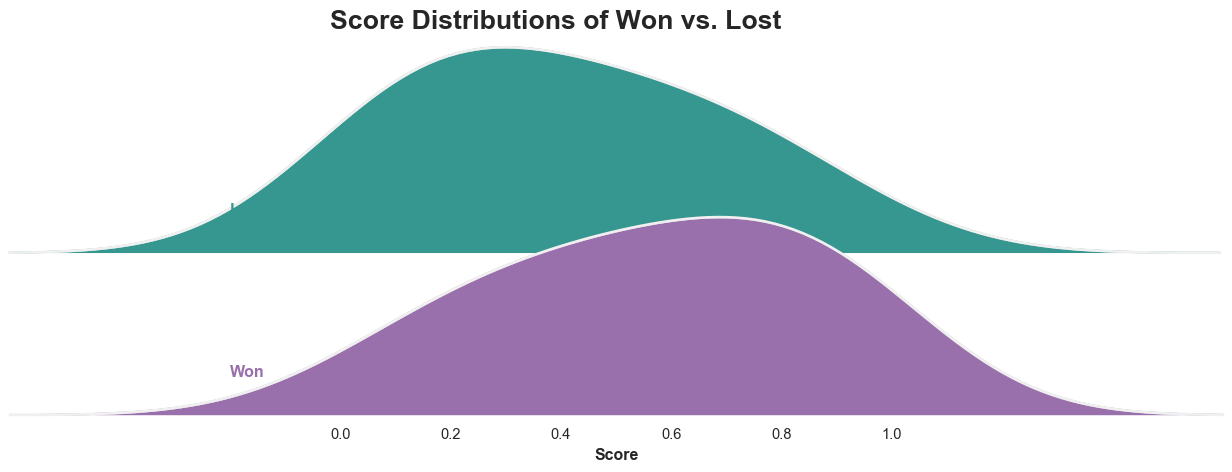

<Figure size 1152x768 with 0 Axes>

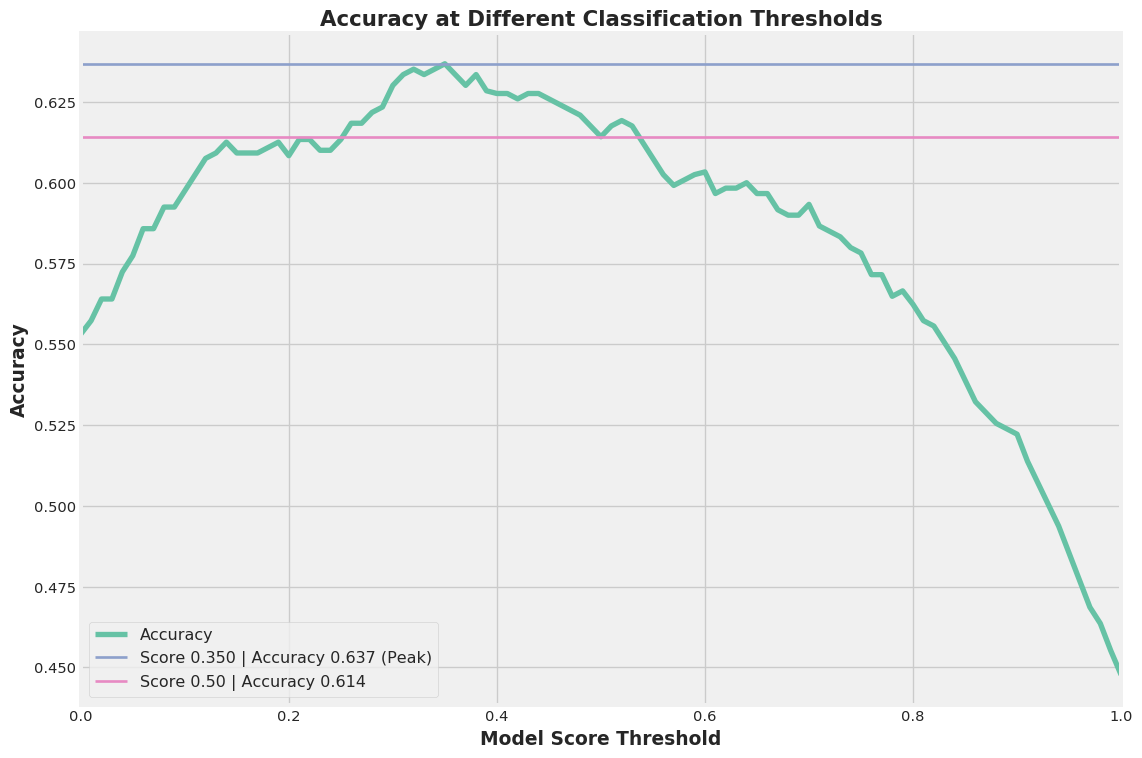

<Figure size 1152x768 with 0 Axes>

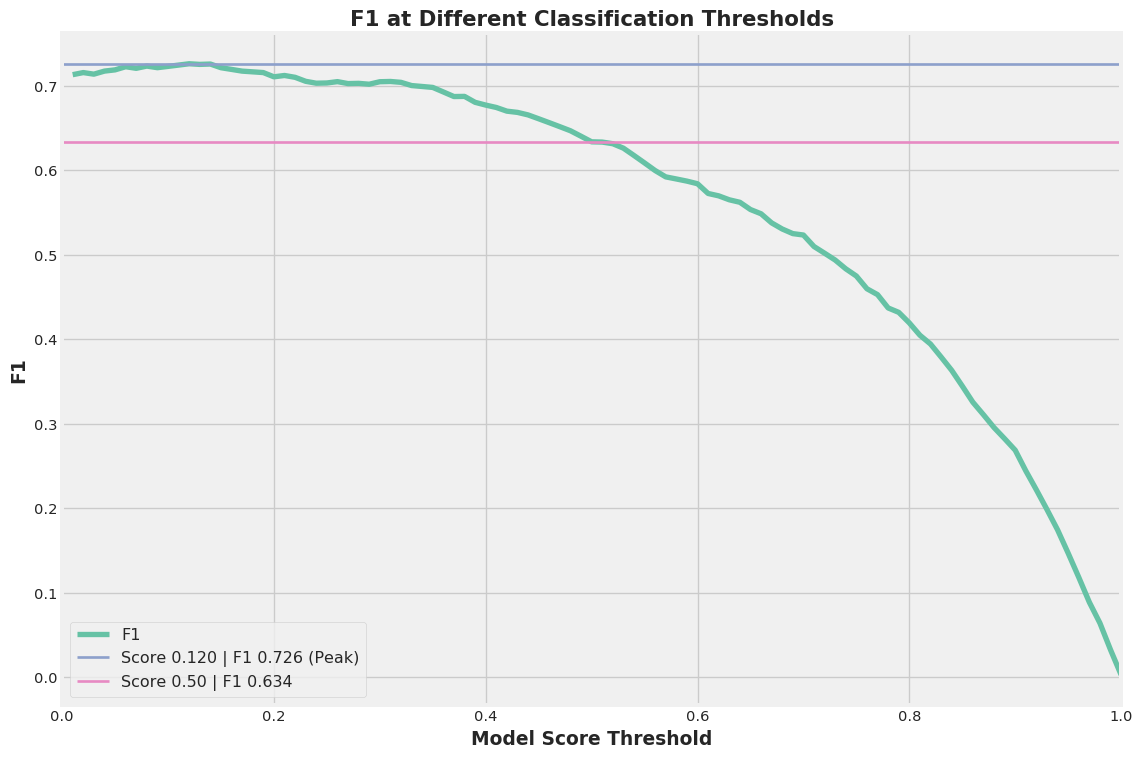

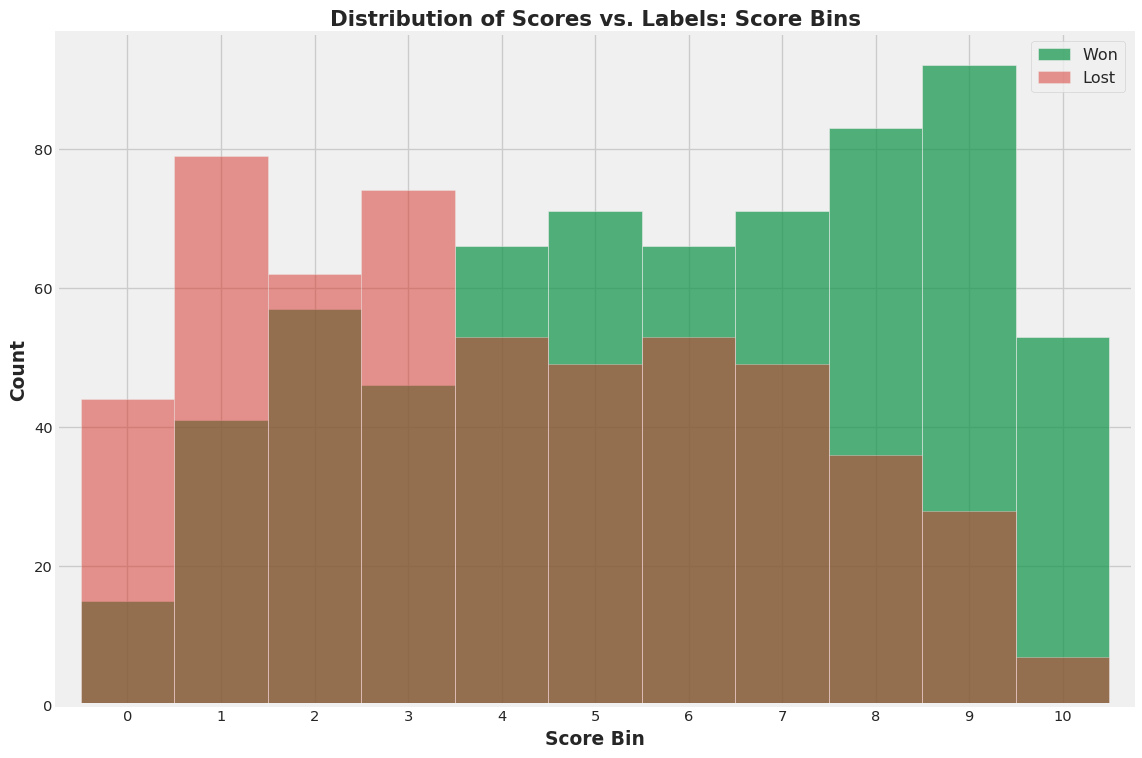

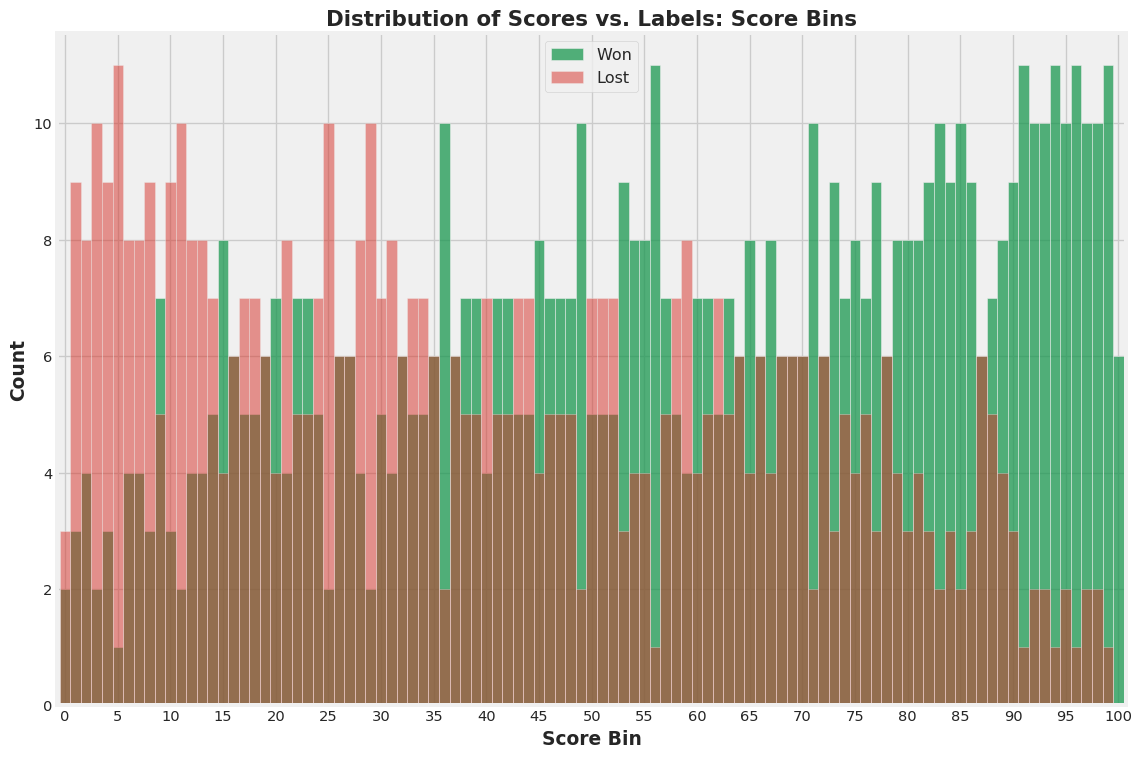

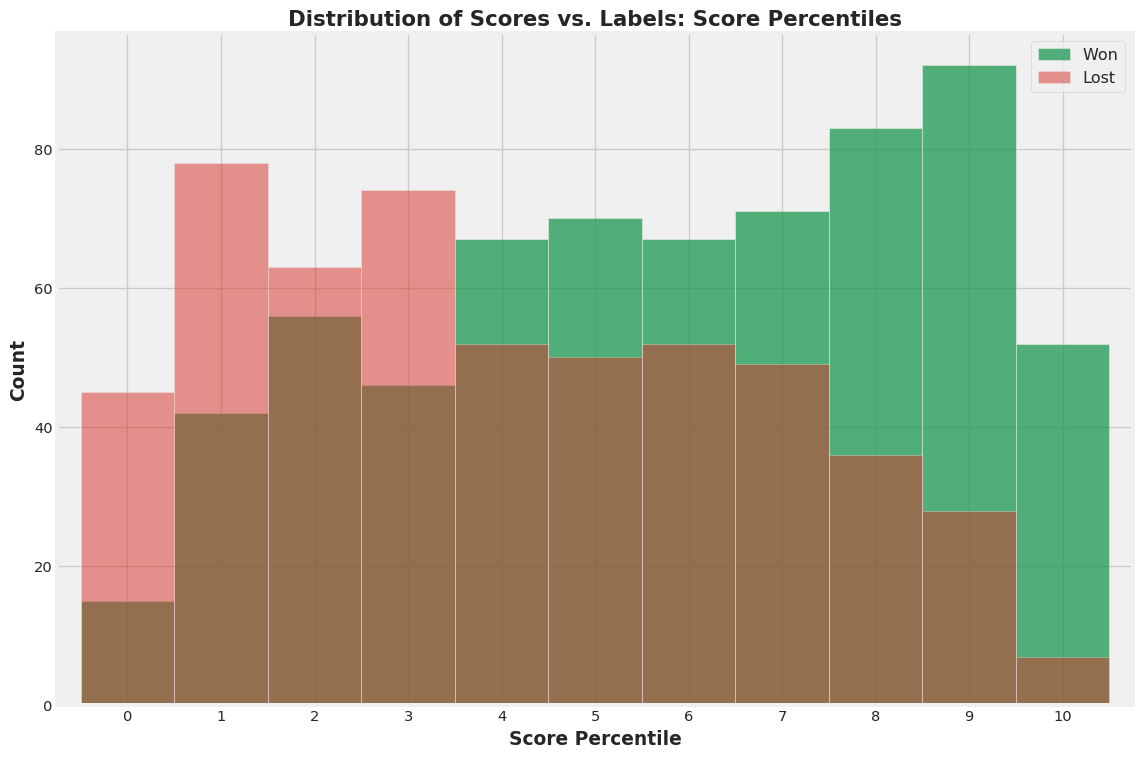

<Figure size 1152x768 with 0 Axes>

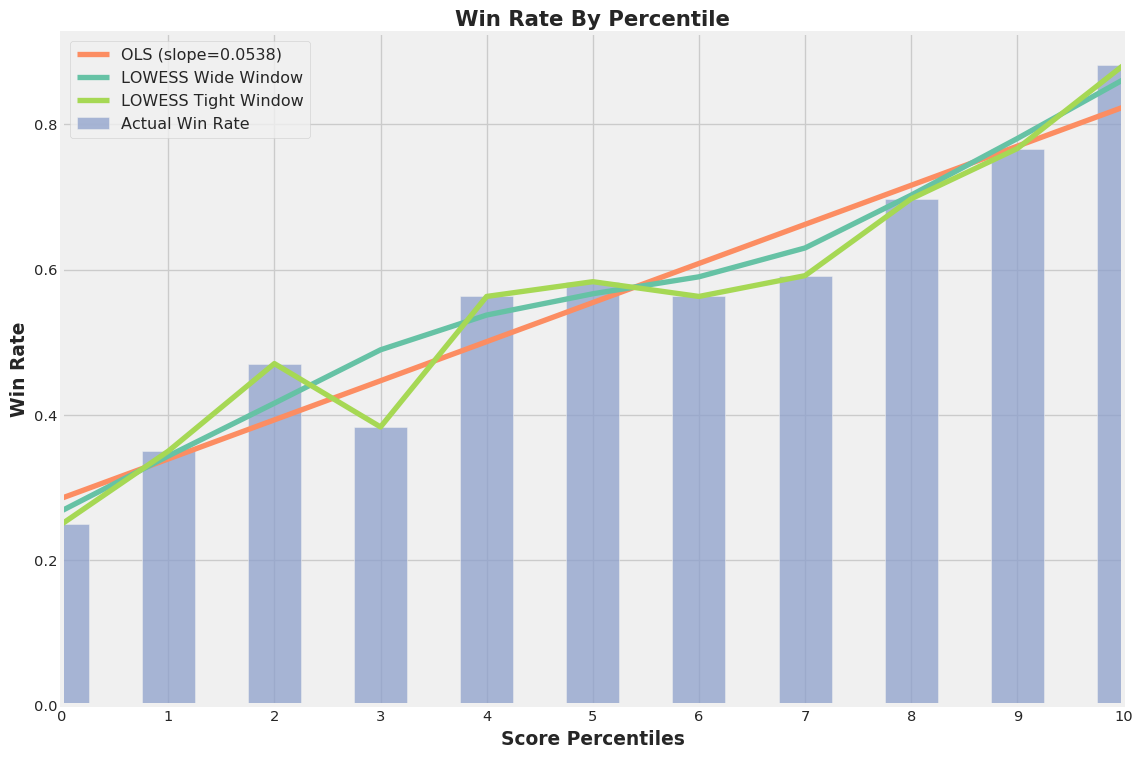

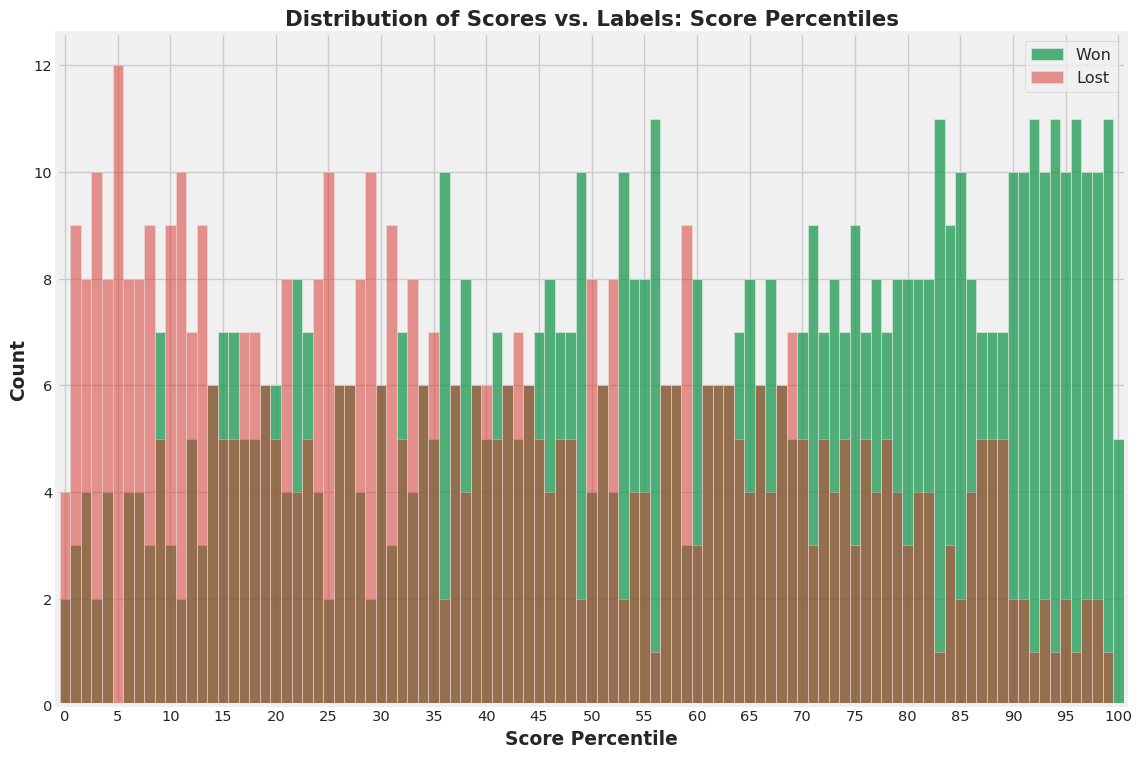

<Figure size 1152x768 with 0 Axes>

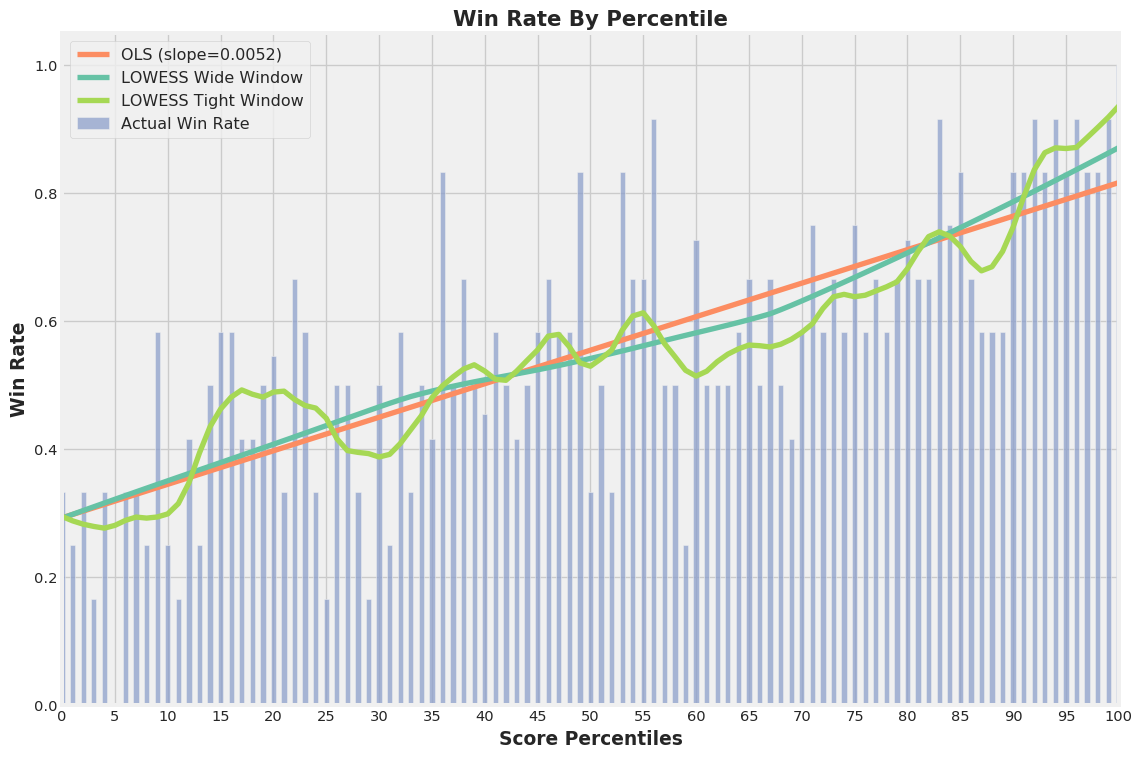

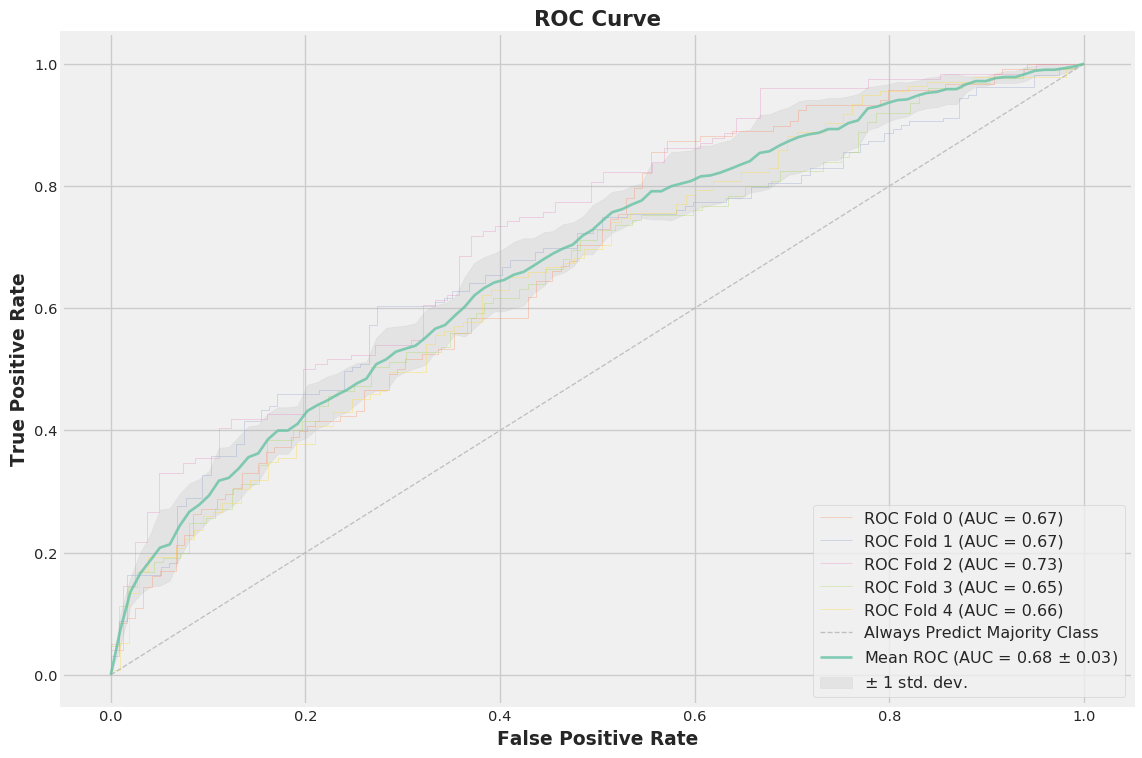

<Figure size 1152x768 with 0 Axes>

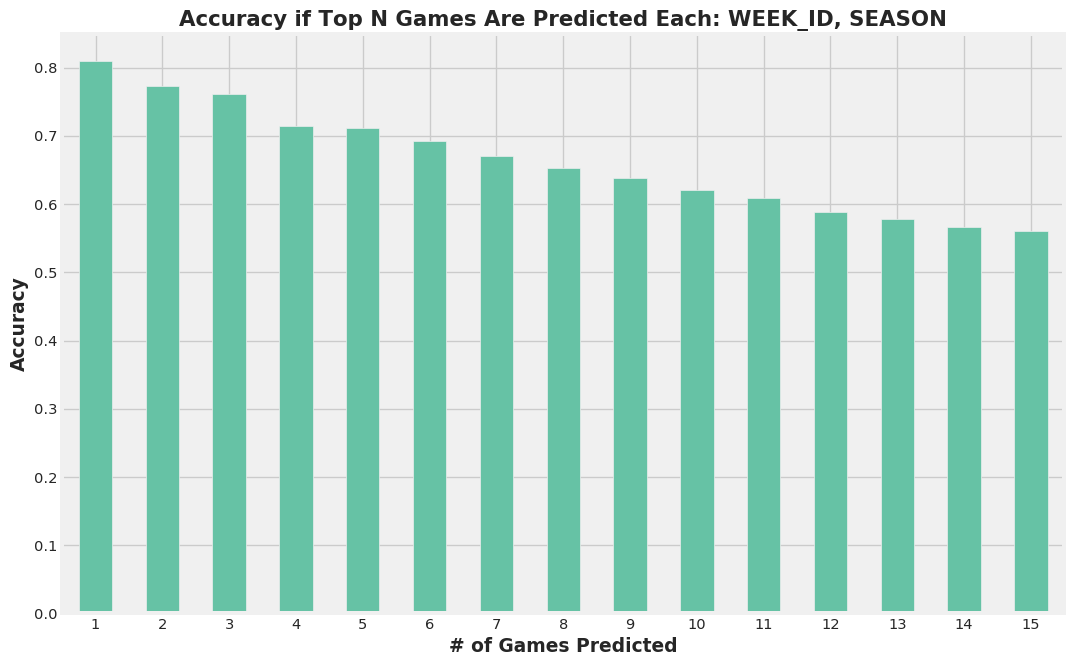

<Figure size 1152x768 with 0 Axes>

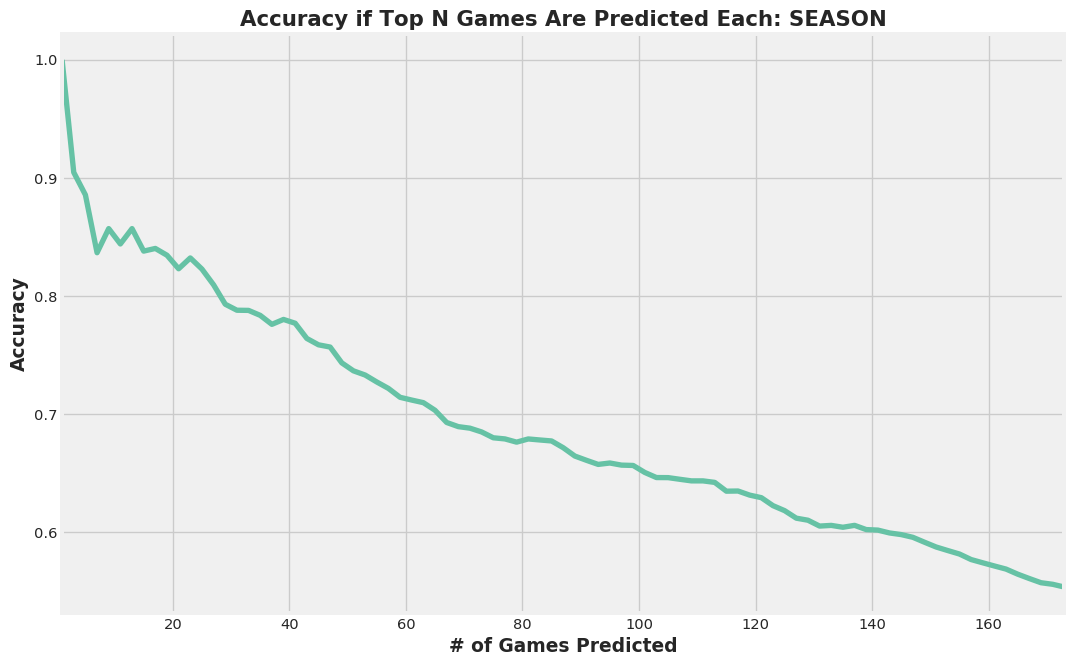

<Figure size 1152x768 with 0 Axes>

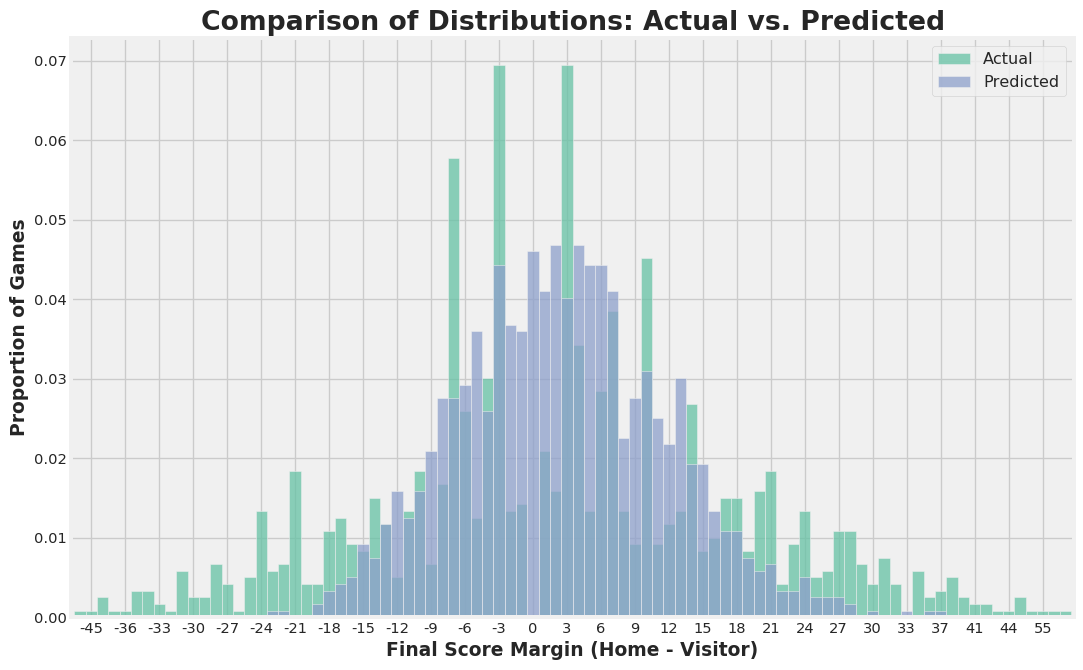

<Figure size 1152x768 with 0 Axes>

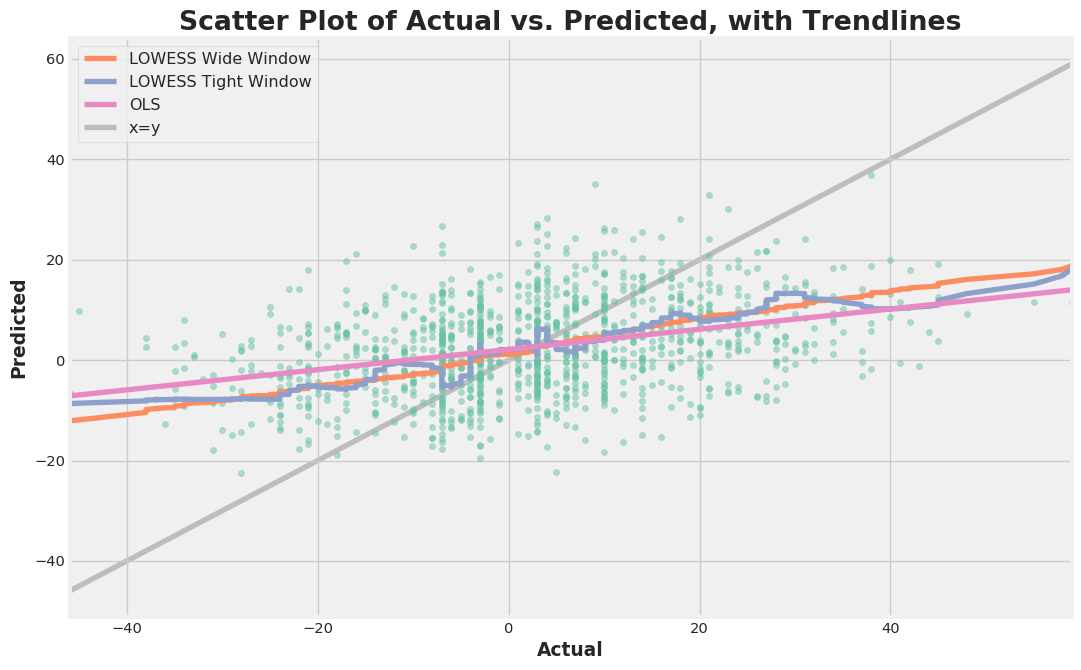

<Figure size 1152x768 with 0 Axes>

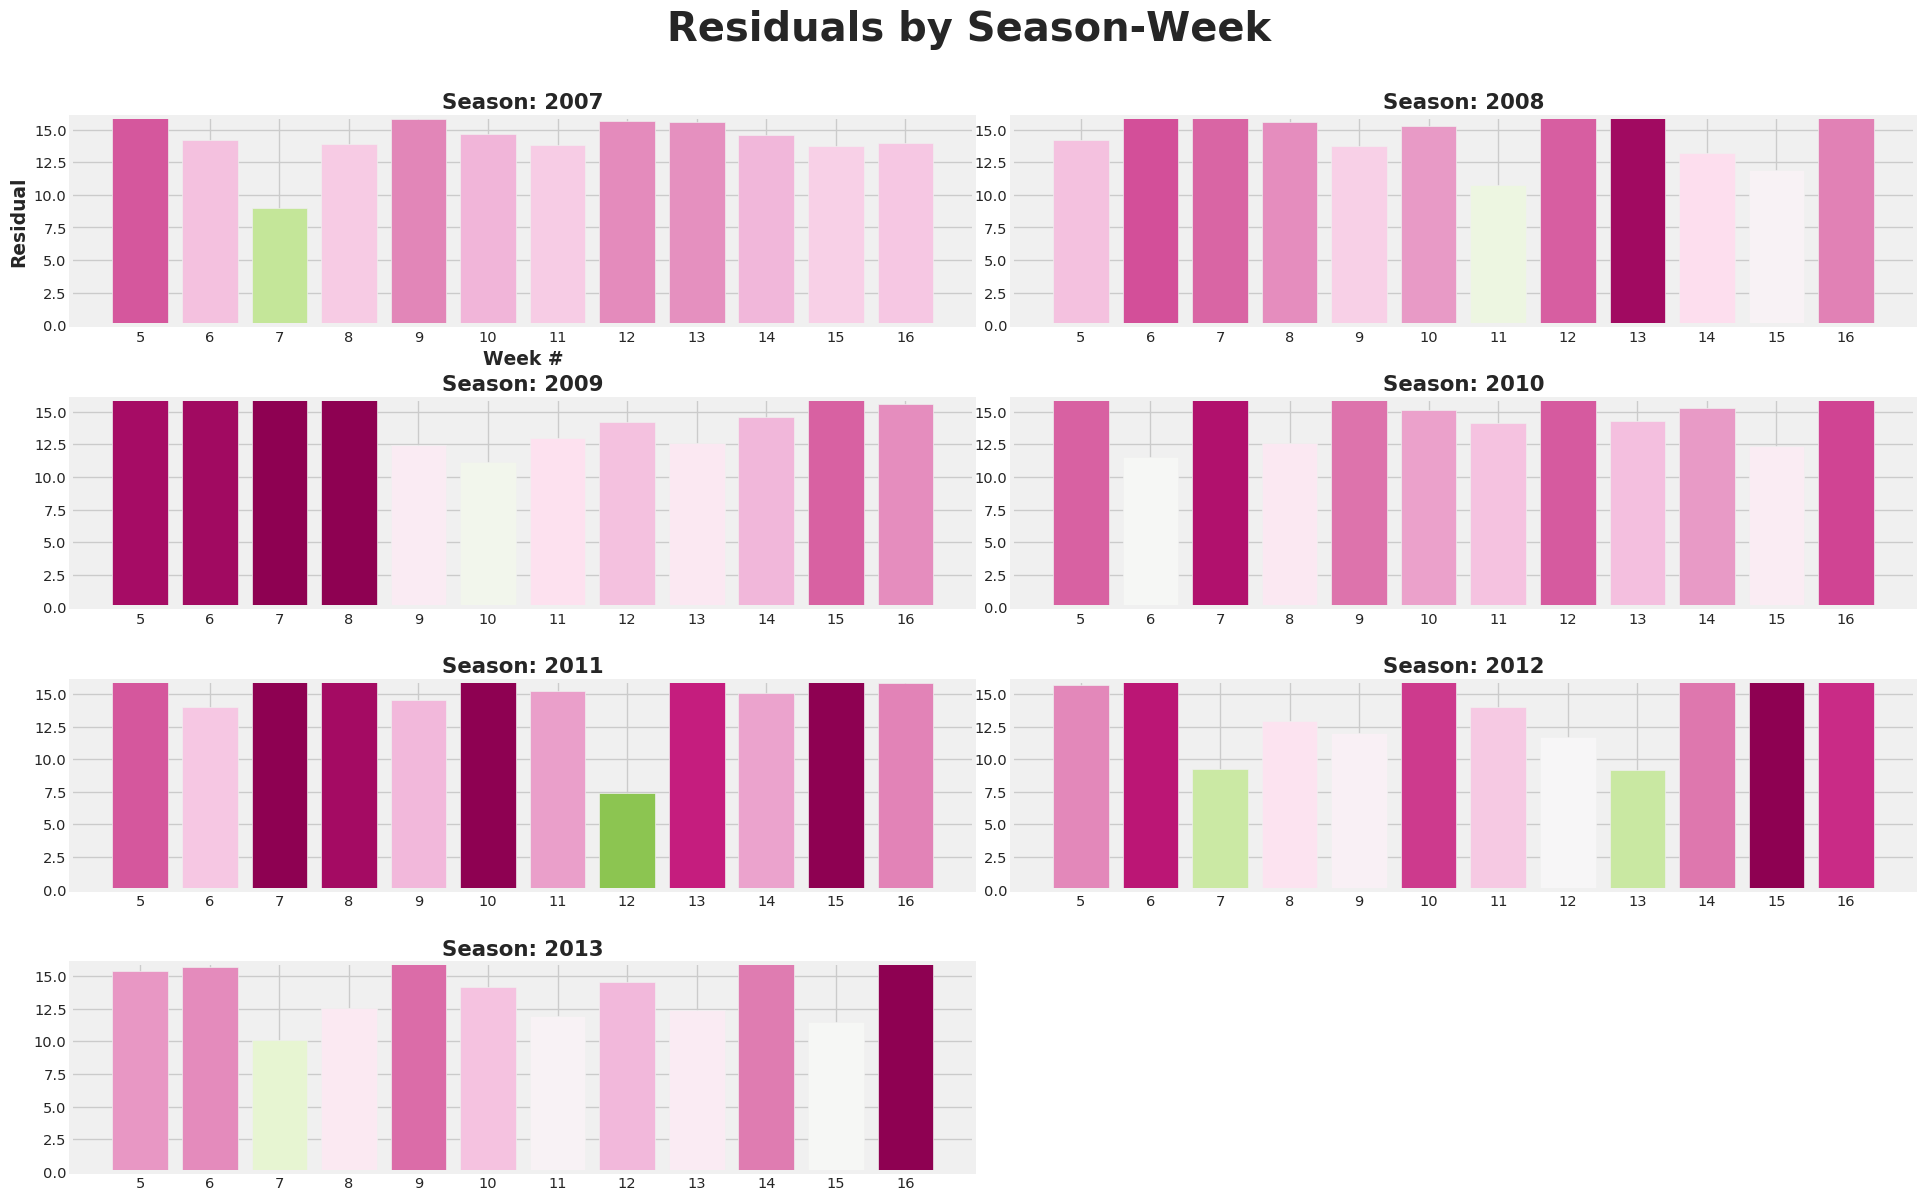

<Figure size 1152x768 with 0 Axes>

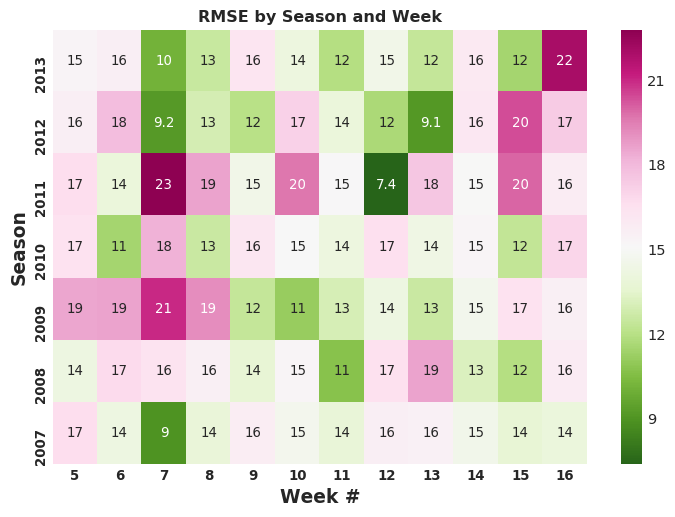

<Figure size 1152x768 with 0 Axes>

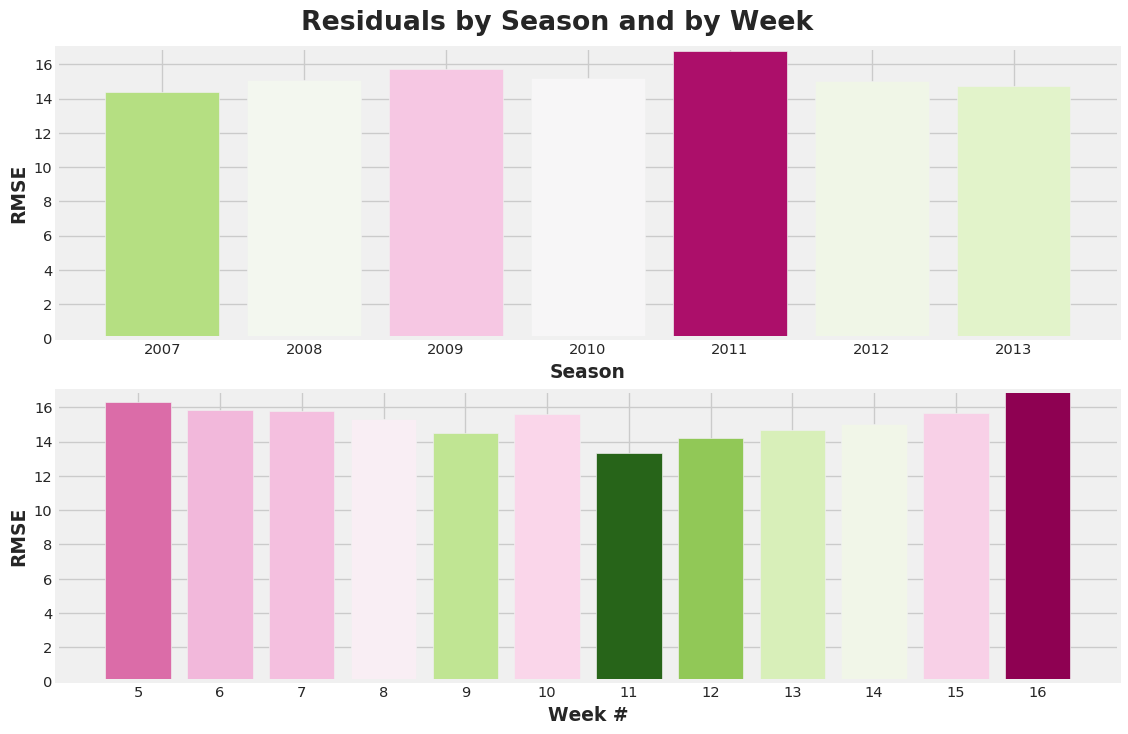

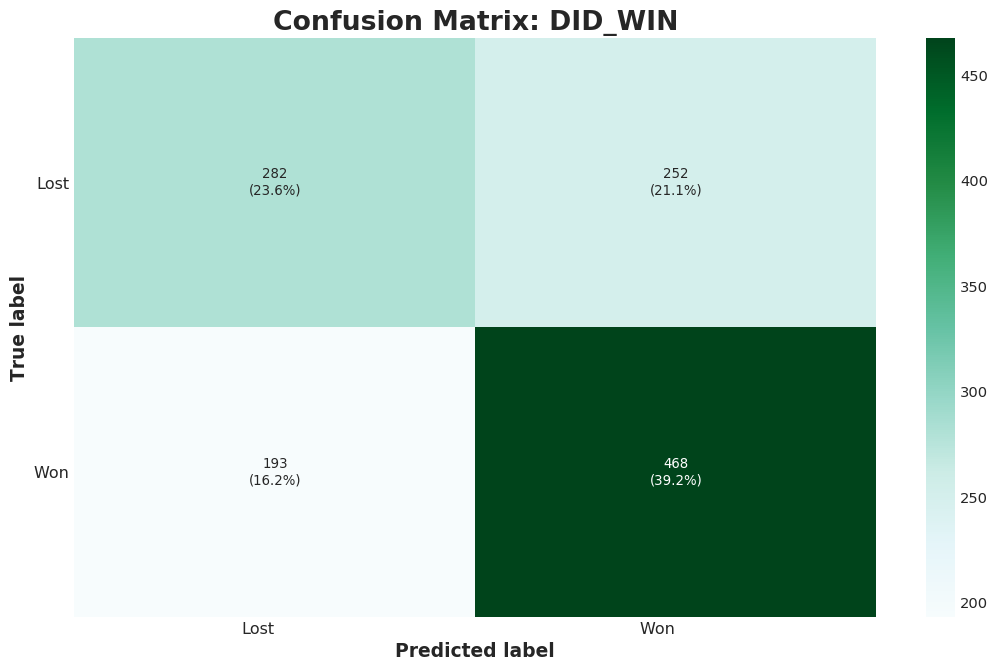

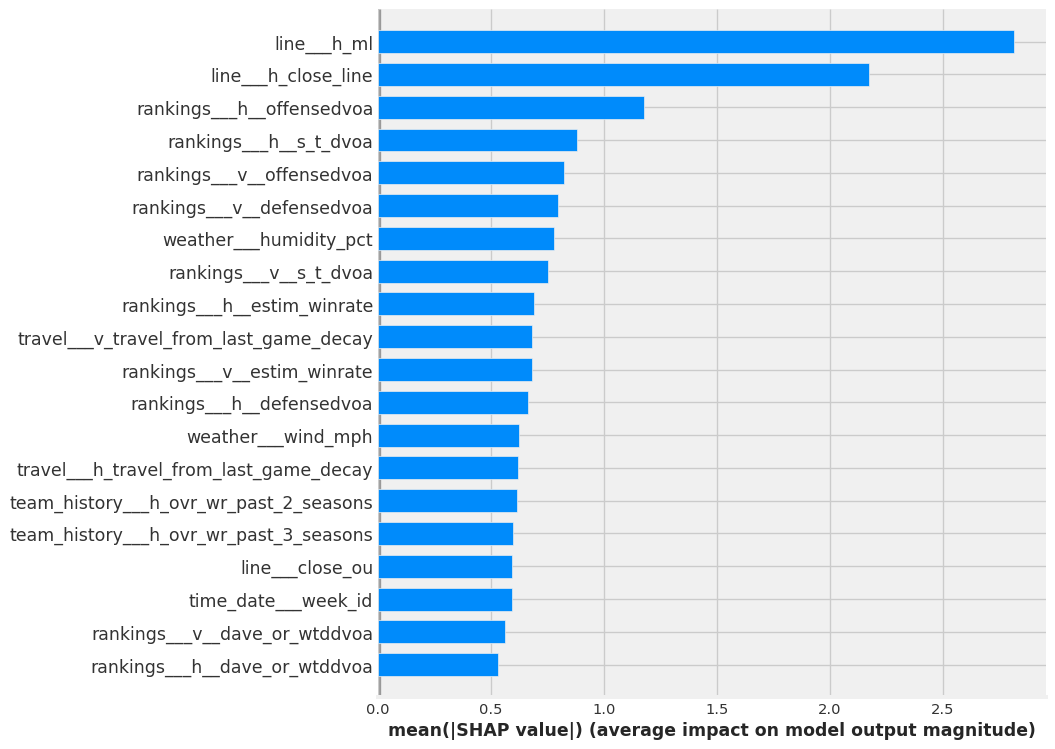

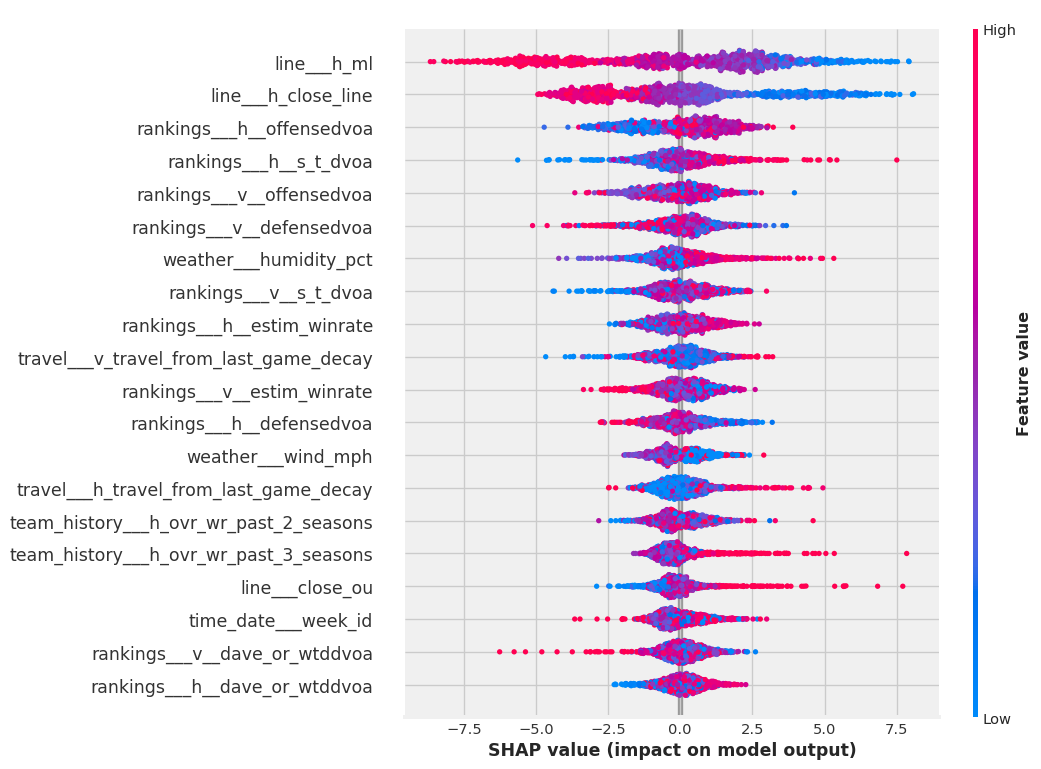

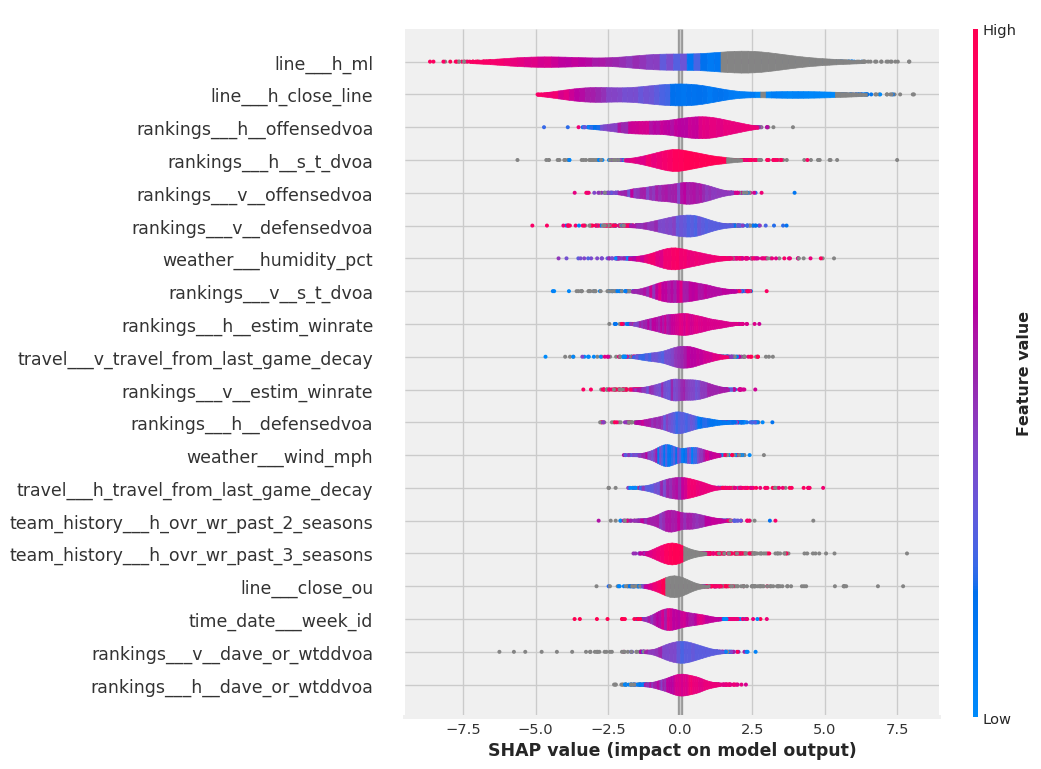

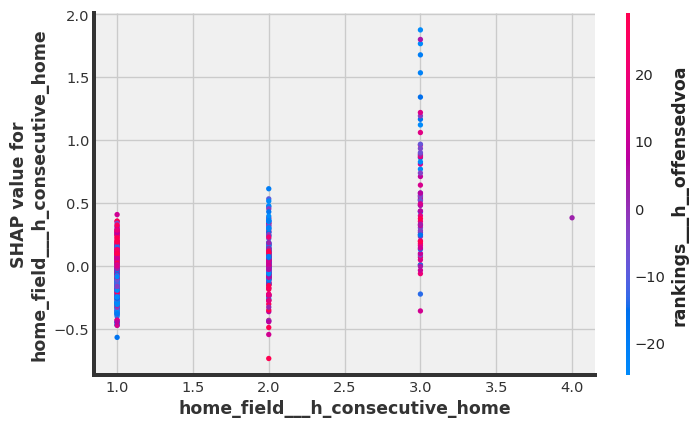

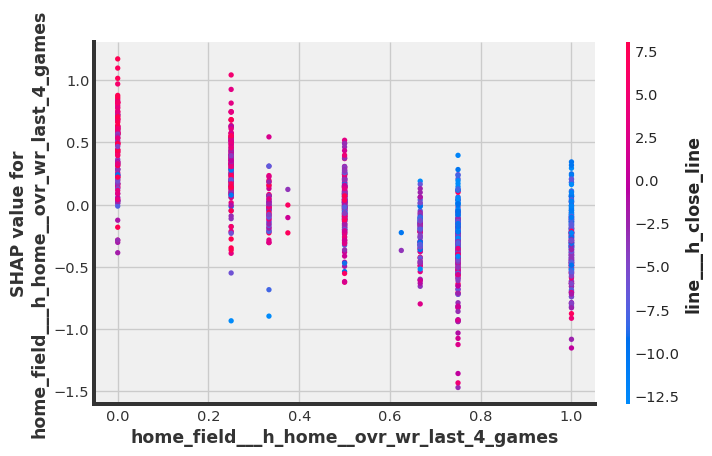

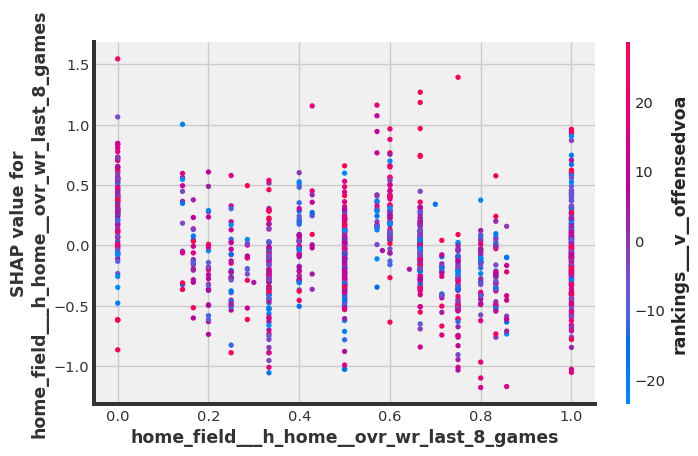

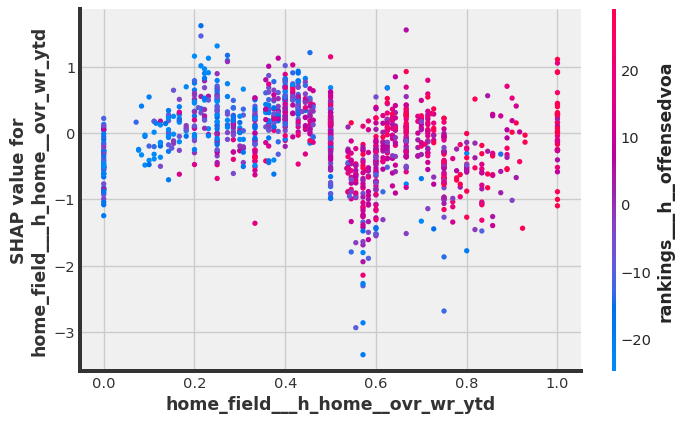

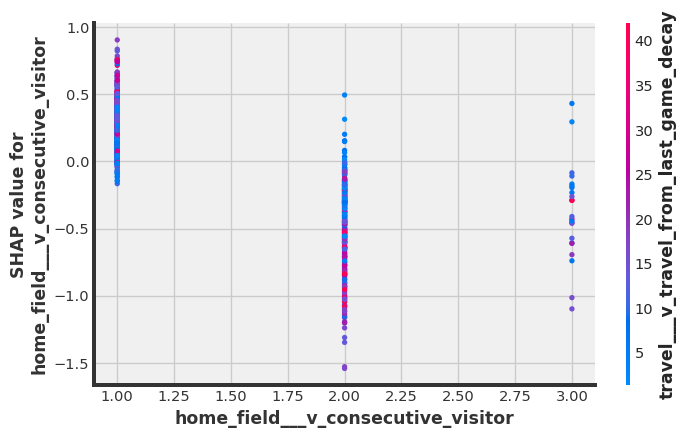

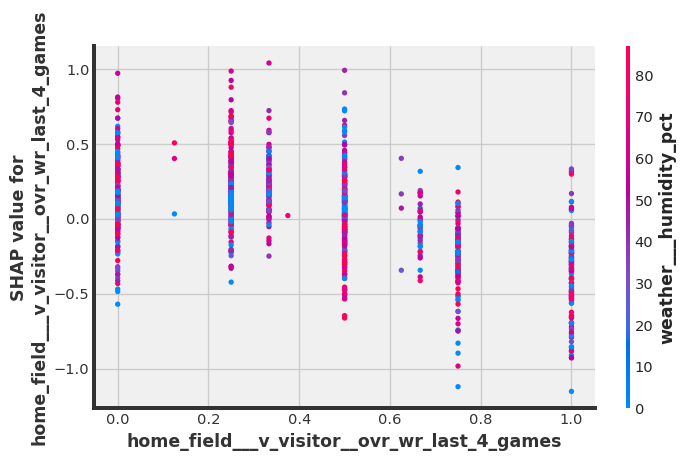

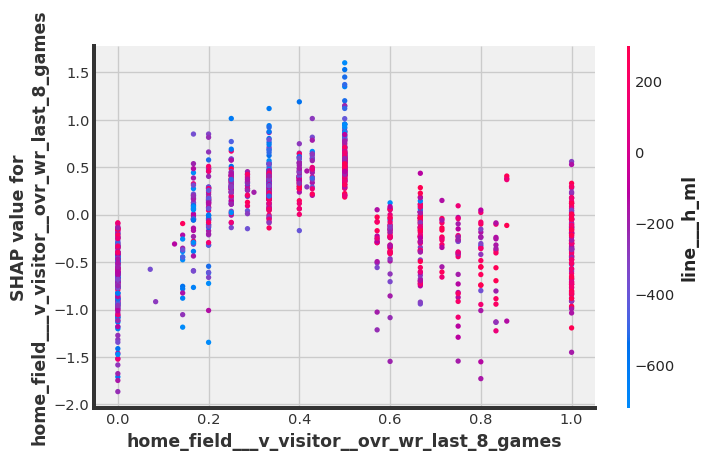

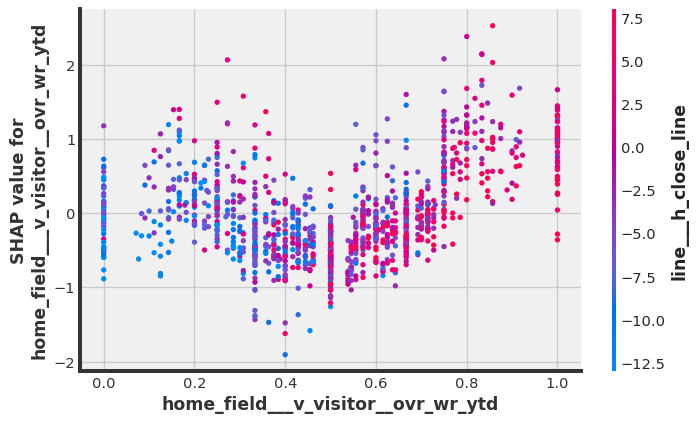

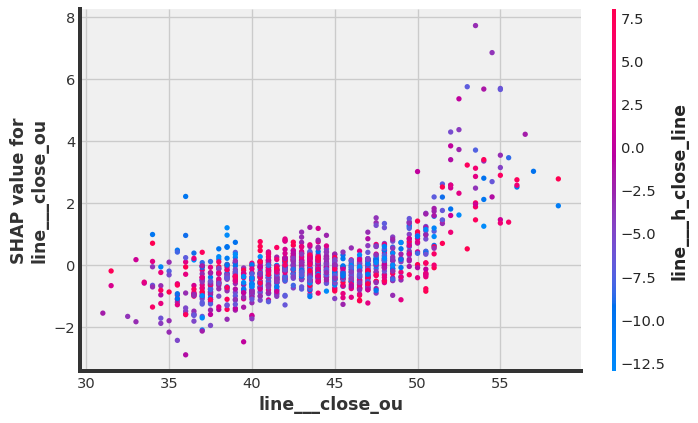

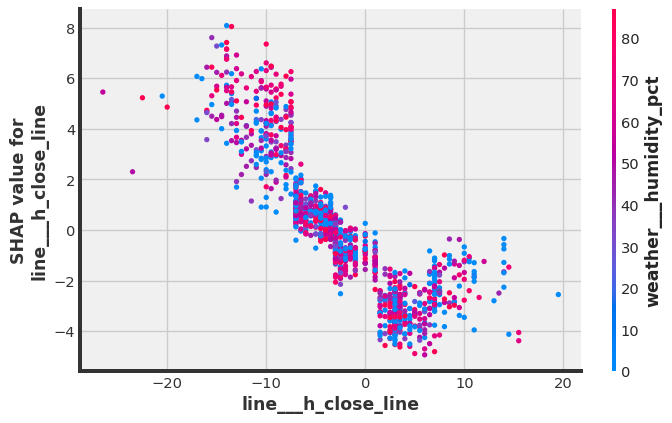

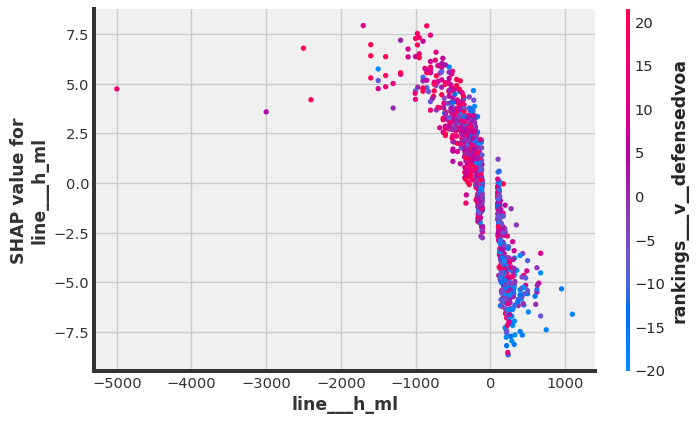

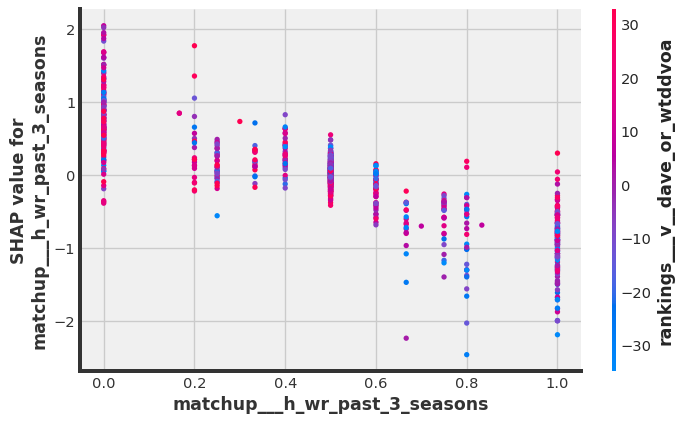

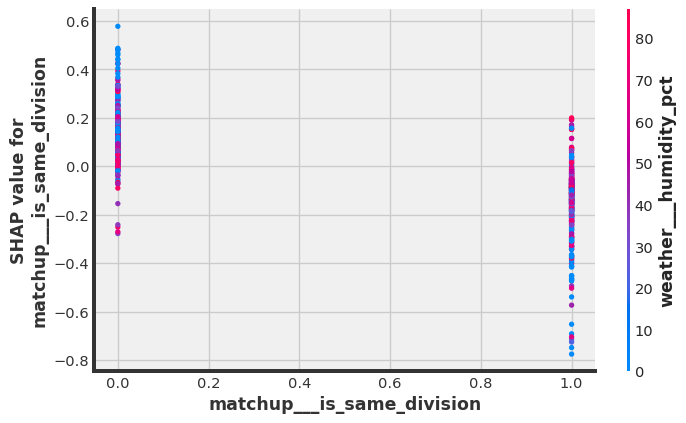

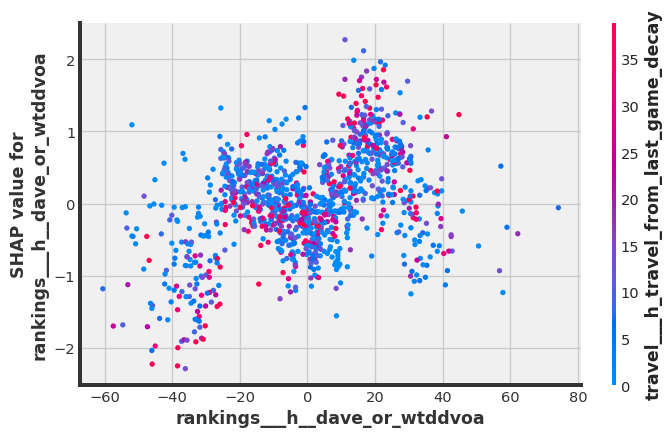

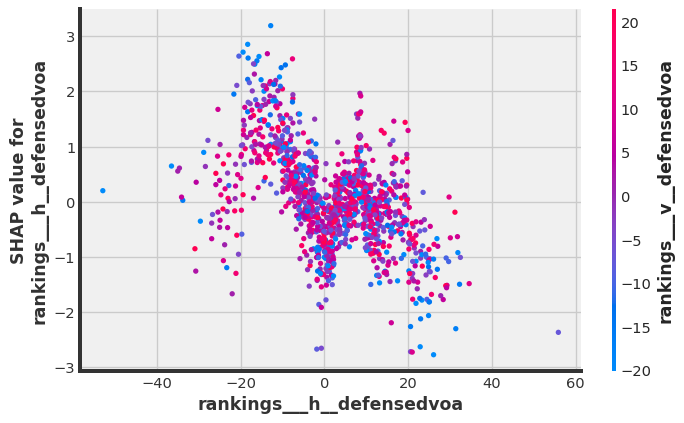

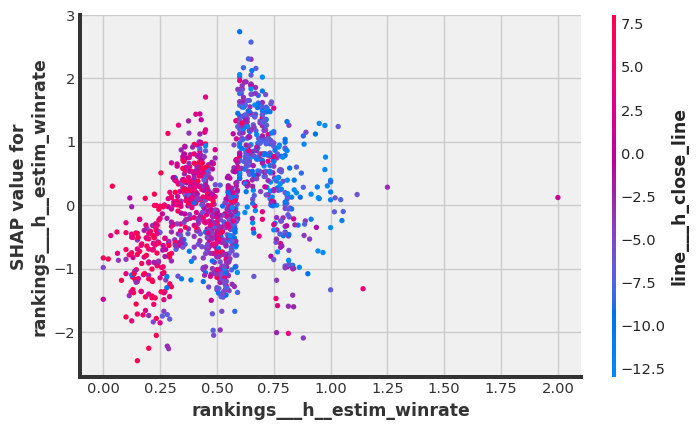

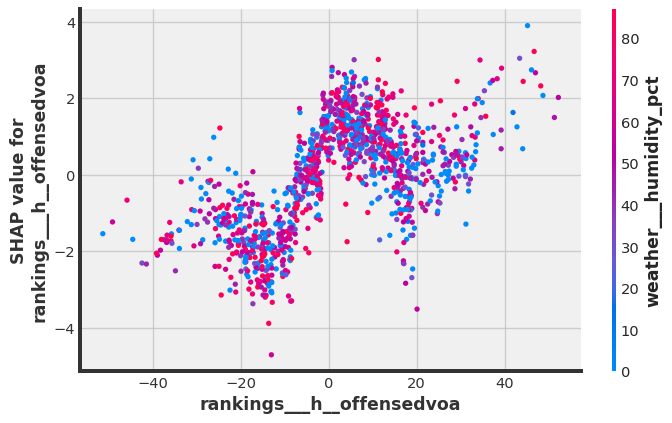

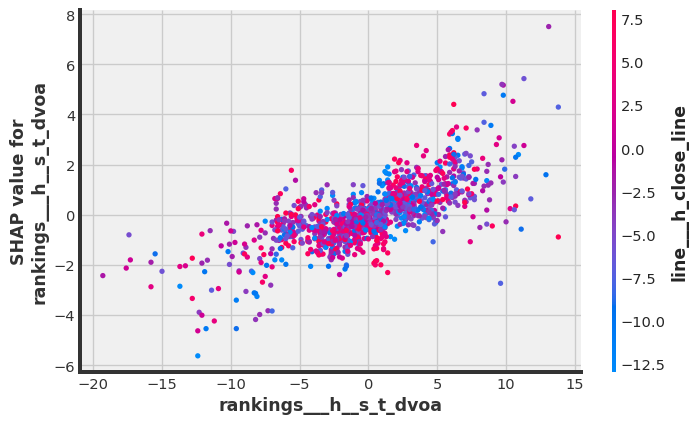

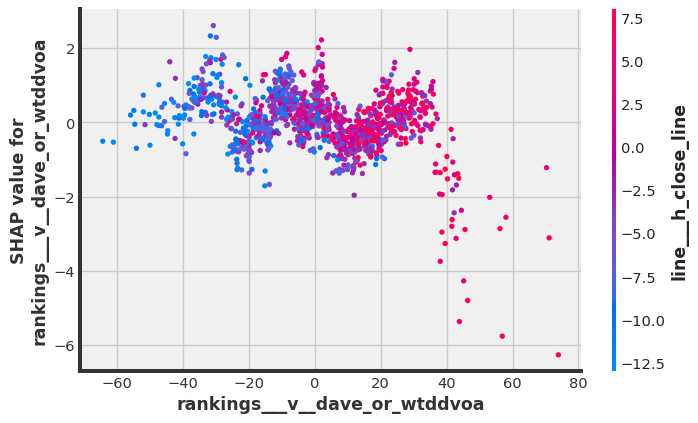

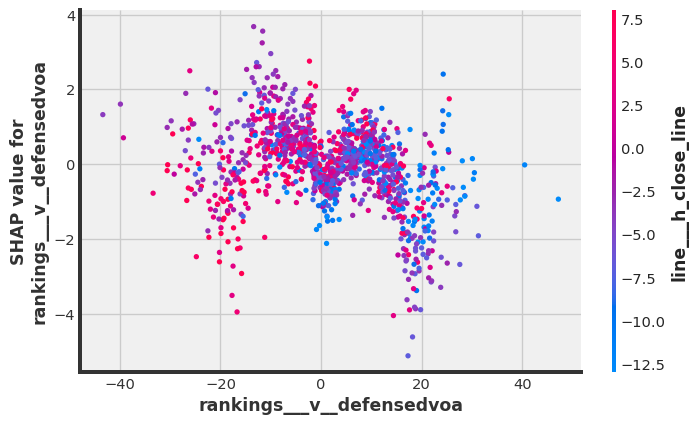

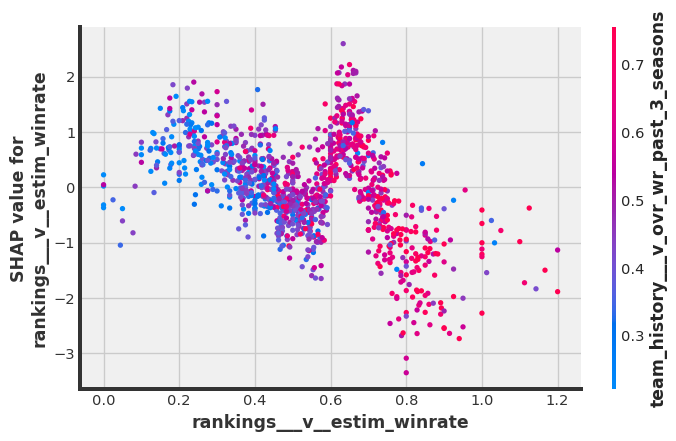

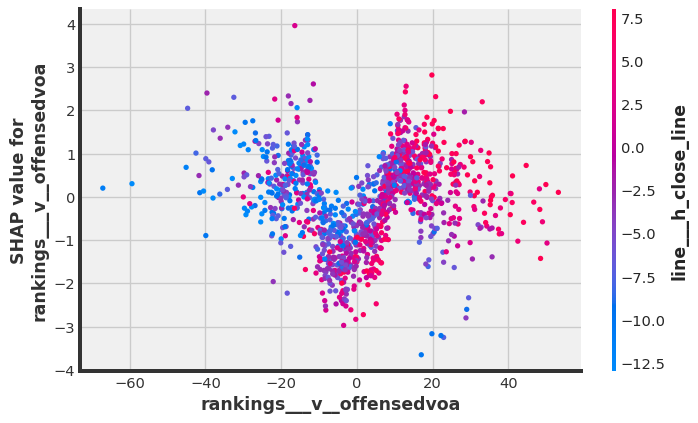

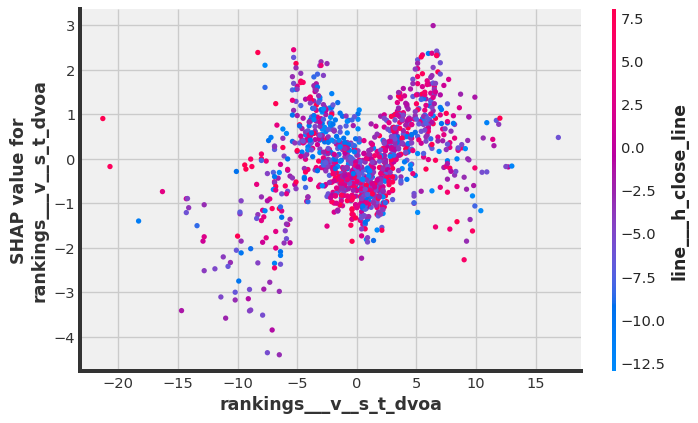

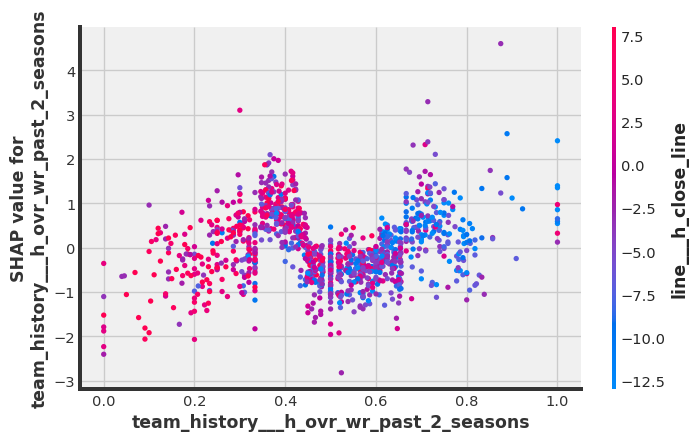

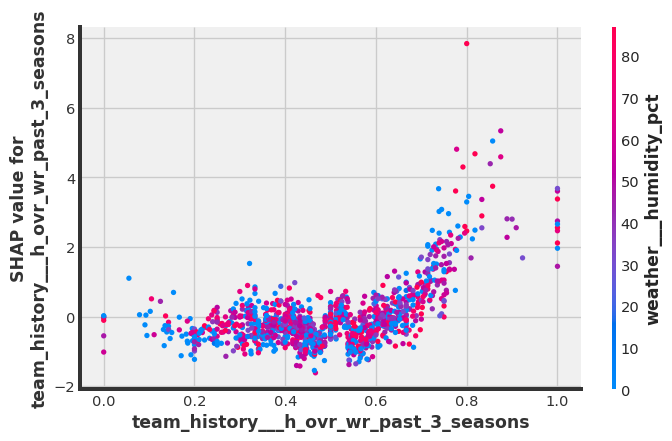

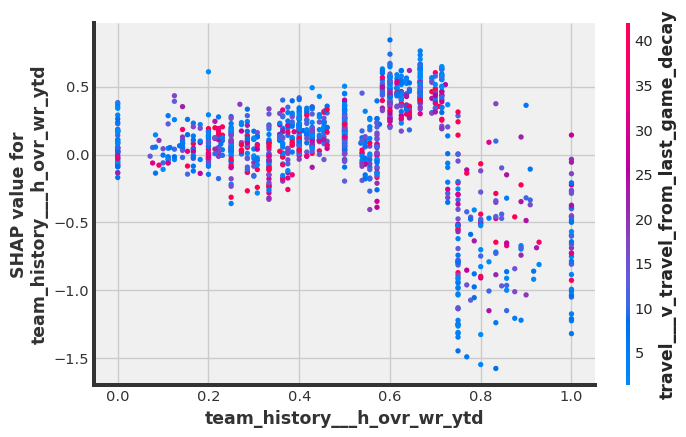

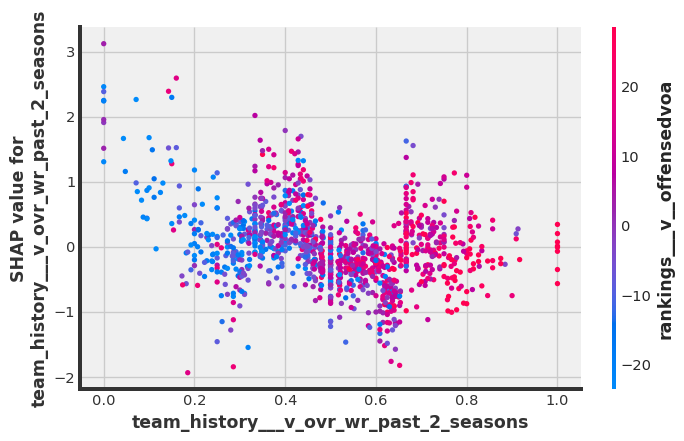

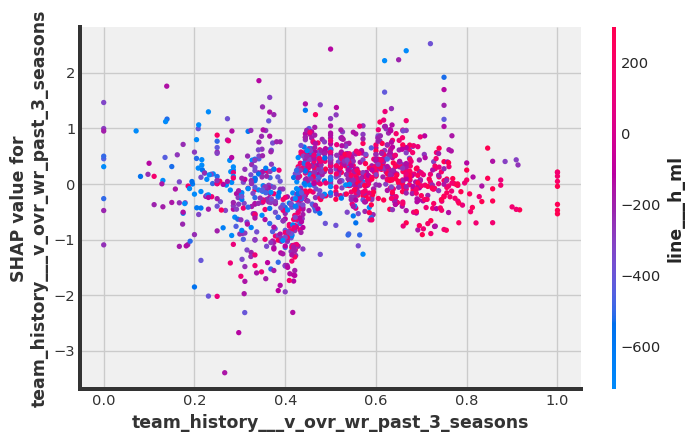

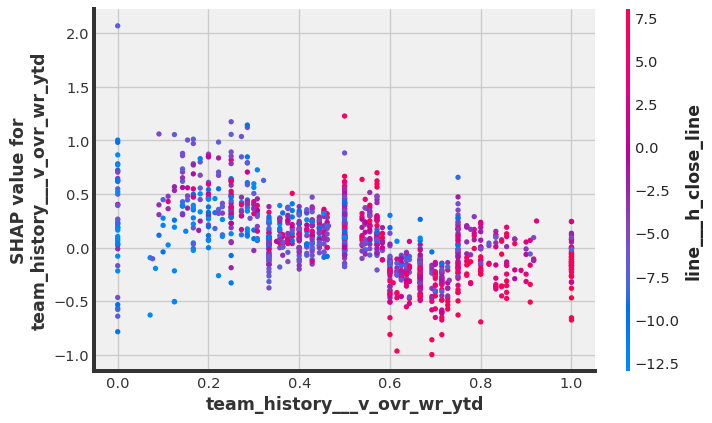

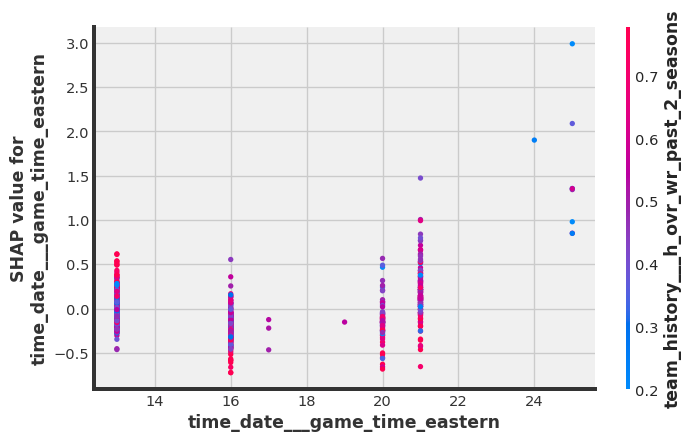

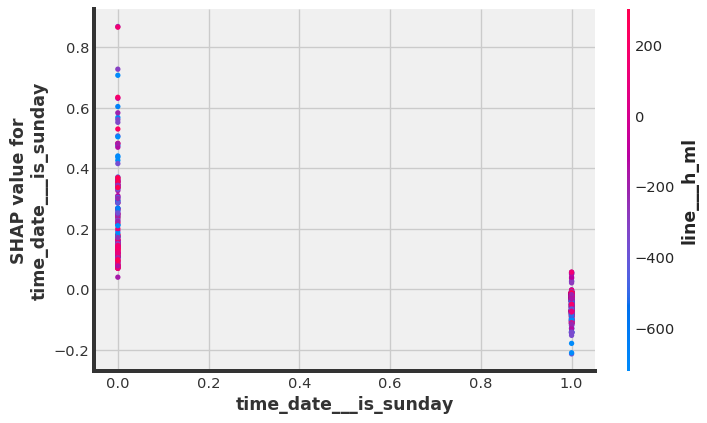

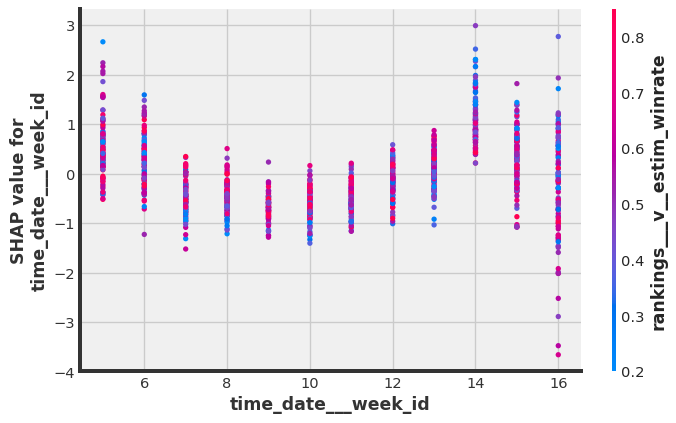

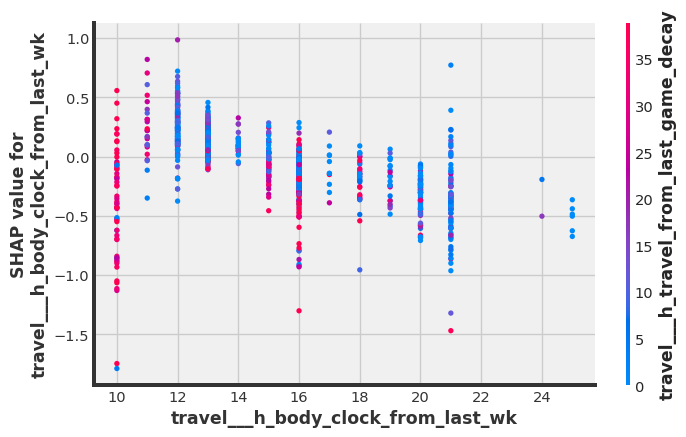

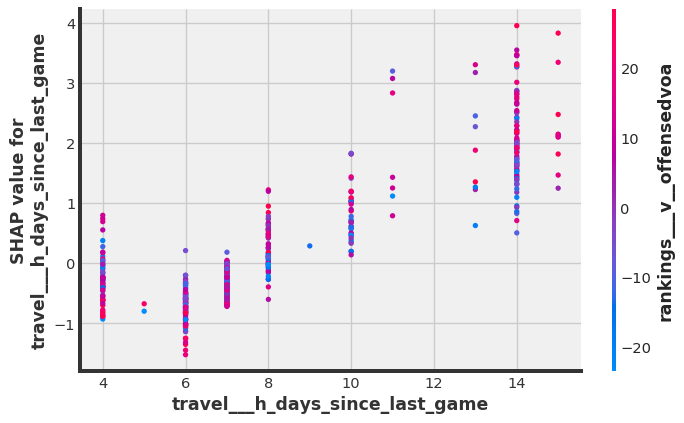

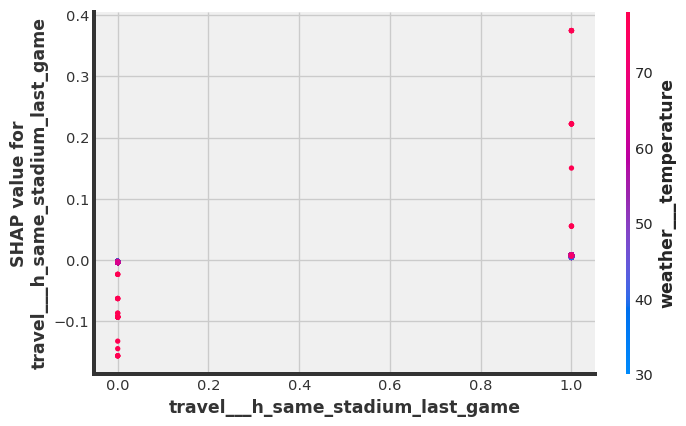

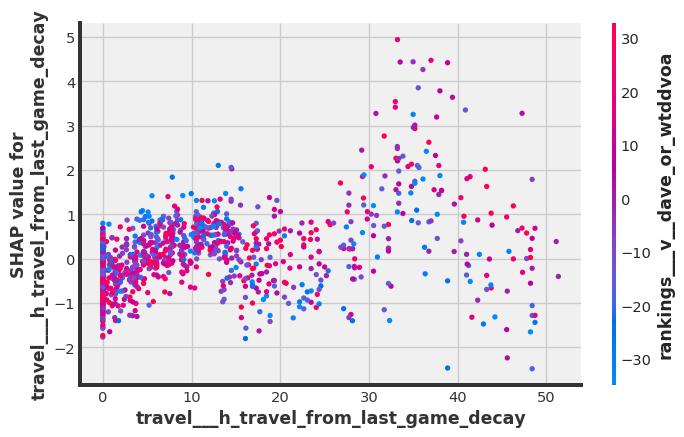

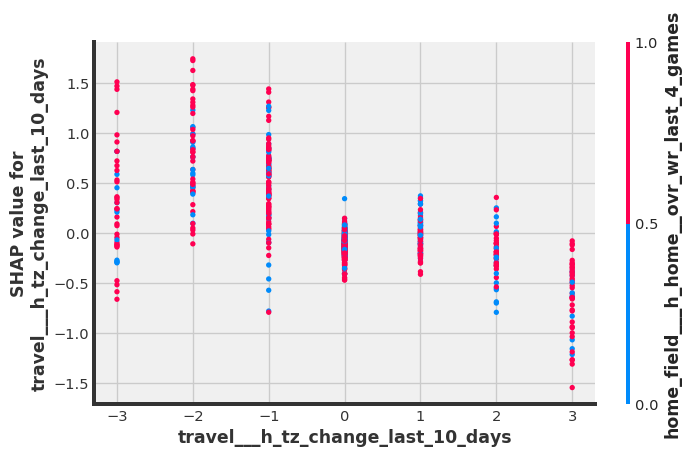

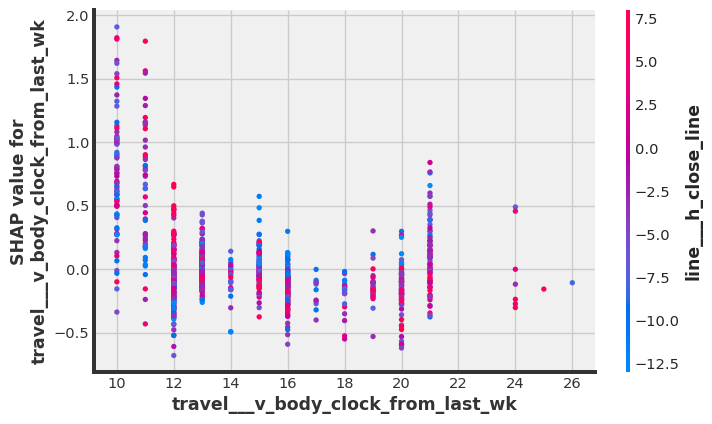

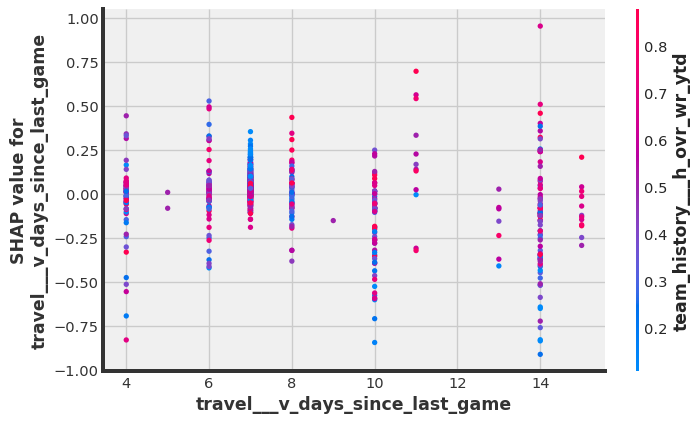

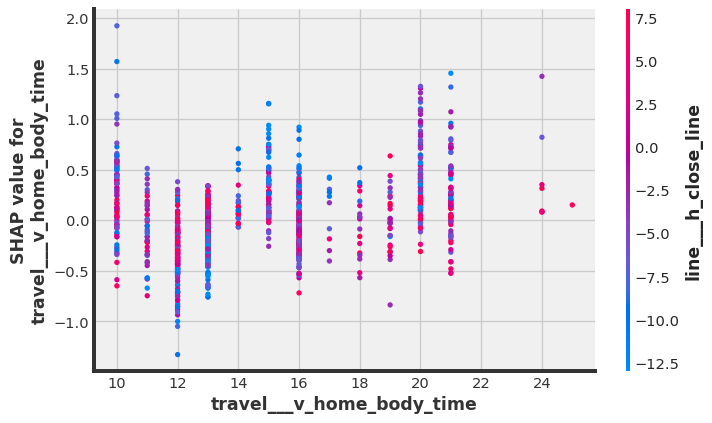

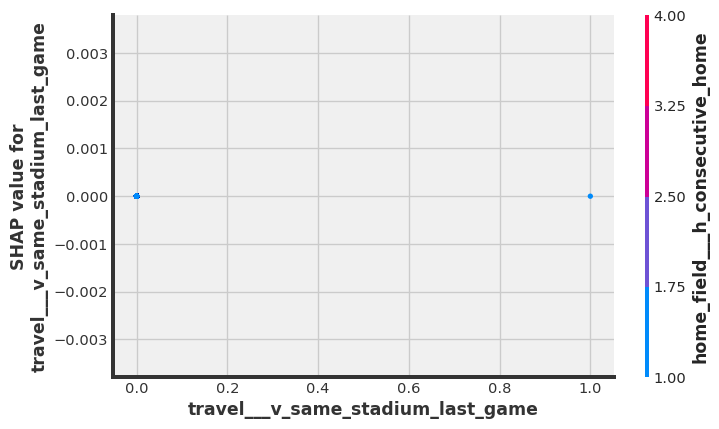

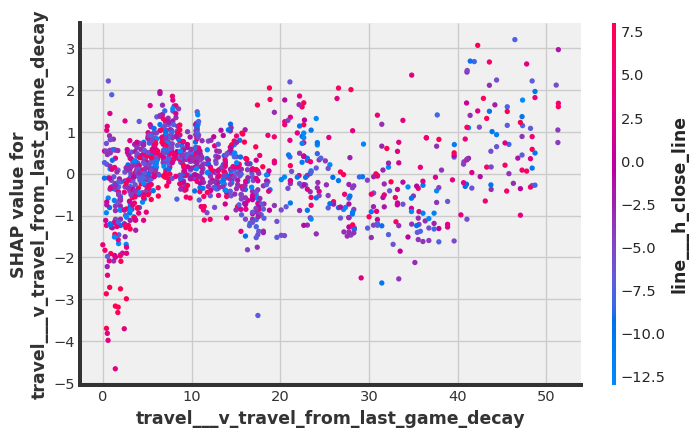

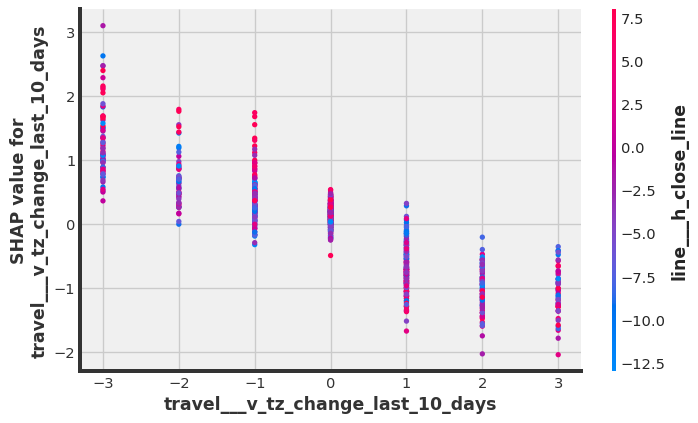

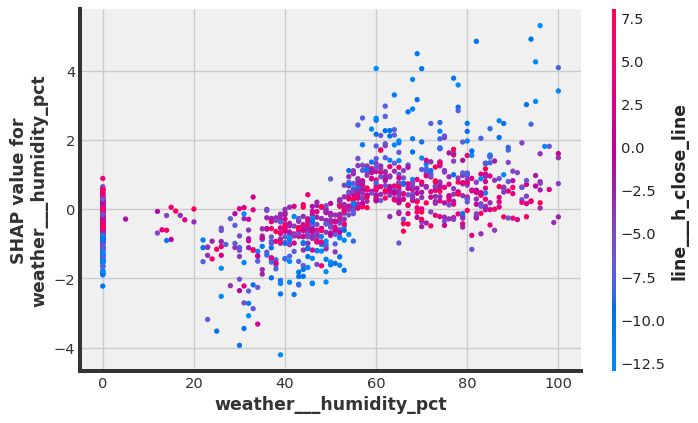

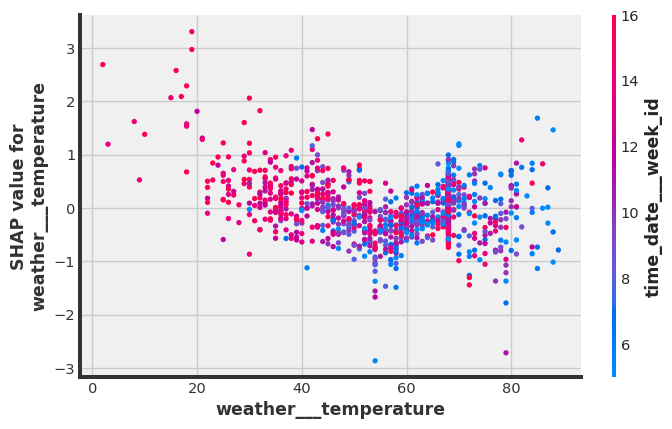

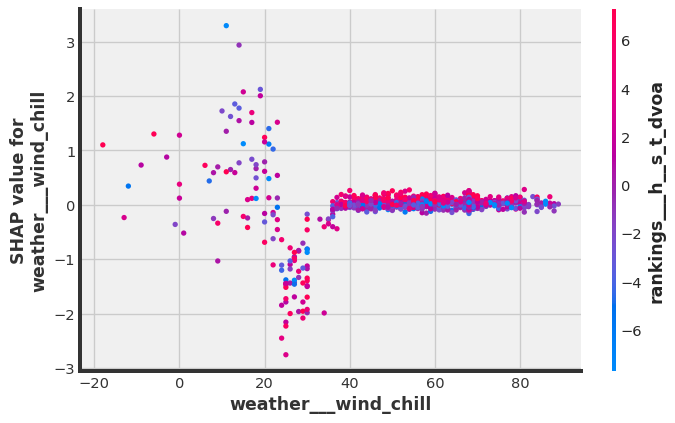

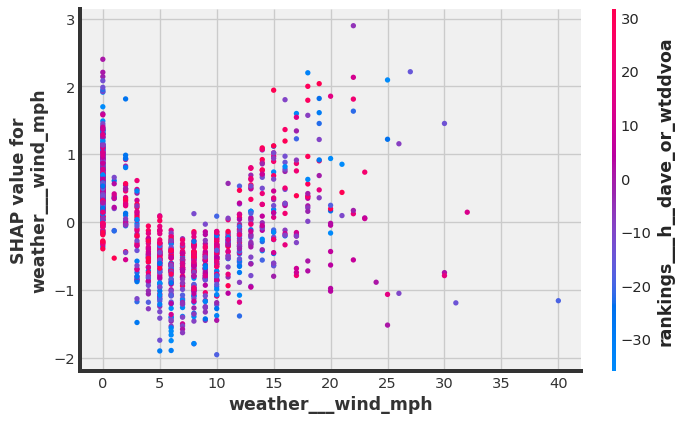

<Figure size 2304x2304 with 0 Axes>

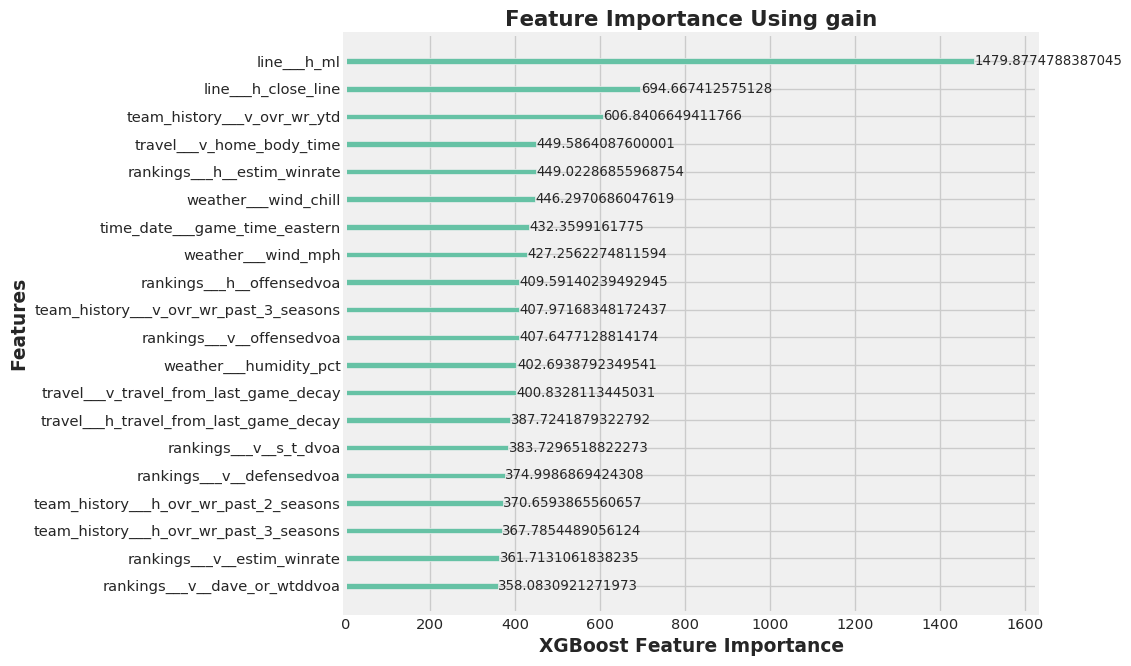

<Figure size 1152x768 with 0 Axes>

In [24]:
from ExecuteModelPipeline import ExecuteModelPipeline
ExecuteModelPipeline(model_json_path, eval_json_path, 'Y')

In [25]:
!open {MODELS_DIR}/{MODEL_ID}